# TP Final

#Imports y funciones auxiliares

## Imports

In [3]:
library(MASS)
library(ggplot2)
library(rpart)
library(class)
library(knitr)

In [ ]:
install.packages("aplpack", dependencies = T)
library(aplpack)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tkrplot’, ‘jpeg’, ‘png’


Warning message:
“no DISPLAY variable so Tk is not available”


In [ ]:
if (!require(randomForest)) {
  install.packages("randomForest", dependencies = T)
}
library(randomForest)

Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [ ]:
if (!require(kernlab)) {
  install.packages("kernlab", dependencies = T)
}
library(kernlab)

Loading required package: kernlab

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘kernlab’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha




In [ ]:
if (!require(e1071)) {
  install.packages("e1071", dependencies = T)
}
library(e1071)

Loading required package: e1071

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘mlbench’, ‘randomForest’, ‘SparseM’, ‘slam’




In [ ]:
if (!require(xgboost)) {
  install.packages("xgboost", dependencies = T)
}
library(xgboost)

Loading required package: xgboost

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘xgboost’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘zoo’, ‘lazyeval’, ‘visNetwork’, ‘Rdpack’, ‘lmtest’, ‘cyclocomp’, ‘rex’, ‘xmlparsedata’, ‘DiagrammeR’, ‘Ckmeans.1d.dp’, ‘vcd’, ‘lintr’, ‘igraph’, ‘float’, ‘titanic’




## Métodos selección de variables

### Wrapper Greedy Forward

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante
#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{
	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>0){
		cat("\nFinal ranking ")
		cat("\nFeatures: ",list.feat)
	}

 	return(list.feat)
}

### Wrapper Greedy Backward

In [ ]:
#-------------------------------------------------------------------------------------
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante
#-------------------------------------------------------------------------------------
backward.ranking <- function(x, y, method, verbosity=0, ...) {
	max.feat <- dim(x)[2]      # total de features
	num.feat <- max.feat       # número actual de features
	list.feat <- 1:max.feat    # lista para guardar los features elegidos, inicializo con todos
	final.feat <- c()

	# Inicialmente, entreno el modelo con todas las variables y mido el error
	x.train <- x
	class.error <- double(max.feat)  # inicializo el vector para guardar el error de cada modelo
	full.error <- do.call(method, c(list(x.train, y), list(...)))

	if (verbosity > 1) cat("\nInitial error with all features: ", full.error, "\n")

	# Loop principal. En cada paso, elimino una variable, entreno el modelo y mido el error.
	while (num.feat > 1) {
		class.error <- double(num.feat)

		# Para cada variable que queda, la elimino, entreno el modelo y mido el error.
		for (i in 1:num.feat) {
			features <- list.feat[-i]  # quito una variable
			x.train <- x[, features,drop=F]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
		}

		if (verbosity > 2) cat("\nFeatures:\n", list.feat, "\nErrors:\n", class.error)

		# Me quedo con la eliminación que minimiza el aumento del error.
		worst.index <- which.min(class.error)
		if (verbosity > 1) cat("\n---------\nStep ", max.feat - num.feat + 1, "\nFeature removed: ", list.feat[worst.index], "\n")

		final.feat <- c(final.feat, list.feat[worst.index])
		list.feat <- list.feat[-worst.index]  # elimino el feature de la lista
		num.feat <- num.feat - 1  # actualizo el número de features

		if (verbosity > 2) cat("\nNew feature list: ", list.feat)
	}

	final.feat <- rev(c(final.feat, list.feat[1]))

	if (verbosity > 0) {
		cat("\nFinal ranking ")
		cat("\nFeatures: ", final.feat)
	}

	return(final.feat)
}

### Filter con test no paramétrico Kruskal-Wallis

In [ ]:
# Función para la selección de características usando el test Kruskal-Wallis
# input:
# x: matriz de features
# y: vector de respuesta (debe ser categórico para Kruskal-Wallis)
# verbosity: nivel de detalle en los mensajes impresos
# output:
# ranked.features: índices de las características ordenadas por importancia
kruskal.ranking <- function(x, y, verbosity = 0) {
  max.feat <- dim(x)[2]  # total de features
  statistics <- double(max.feat)  # vector para almacenar los p-valores de cada característica

  # Para cada característica, aplico el test Kruskal-Wallis y guardo el p-valor
  for (i in 1:max.feat) {
    feature <- x[, i]
    statistics[i] <- kruskal.test(feature ~ y)$statistic
    if (verbosity > 1) cat("\nFeature ", i, " statistic: ", statistics[i])
  }

  # Ordeno las características según el p-valor (menor p-valor es mayor importancia)
  ranked.features <- order(statistics, decreasing=T)

  if (verbosity > 0) {
		cat("\nFinal ranking ")
    cat("\nFeatures: ", ranked.features)
    if (verbosity > 1) cat("\nStatictics: ", statistics[ranked.features], "\n")
  }

  return(ranked.features)
}

### RFE

In [ ]:
# Función para selección de características usando Recursive Feature Elimination (RFE)
# input:
# x: matriz de features
# y: vector de respuesta
# method: función para entrenar un modelo que calcule la importancia de las características
# ...: parámetros adicionales para el método 'method'
# verbosity: nivel de detalle en los mensajes impresos
# output:
# R: índices de las características seleccionadas, ordenadas de más a menos importante
rfe.ranking <- function(x, y, method, verbosity = 0, ...) {
  p <- dim(x)[2]  # total de features
  list.feat <- 1:p
  R <- c()
  for(i in 1:p) {
	model <- do.call(method, c(list(x[, list.feat, drop = FALSE], y), list(...)))
	least.important <- model$feats[1]

	if (verbosity > 1) {
      cat("\nIteration with", length(list.feat), "features.")
	  cat("\nFeatures: ", list.feat)
	  cat("\nFeatures indexes: ", model$feats)
      cat("\nFeature importances: ", model$imp)
      cat("\nRemoving feature: ", list.feat[least.important], "\n")
    }

	R[p-i+1] <- list.feat[least.important]
	list.feat <- list.feat[-least.important]
  }

  if (verbosity > 0) {
		cat("\nFinal ranking ")
    cat("\nFeatures: ", R)
  }

  return(R)
}

### Funciones estimacion greedy

In [ ]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	suppressWarnings(m.lda <- lda(x.train,y,CV=TRUE))
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
	return ( model@cross )
}

### Funciones estimacion RFE

In [ ]:
#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

## Métodos comparación clusters y cantidad de clusters

### Comparación

In [ ]:
compare_clusters = function(class, cluster_result) {
  cont.table <- table(class, cluster_result)
  # Find optimal match between the two classifications
  class.match <- matchClasses(as.matrix(cont.table),method="exact")
  # Print the confusion table, with rows permuted to maximize the diagonal
  print(cont.table[,class.match])
}

### GAP Statitic

In [ ]:
gen_uniform_dataset <- function(data) {
  dataset_uniform <- c()
  n_row <- nrow(data)
  n_col <- ncol(data)

  data_pca <- prcomp(data)$x

  for (c in 1:n_col) {
    col <- runif(n_row, min = min(data_pca[,c]), max = max(data_pca[,c]))
    dataset_uniform <- cbind(dataset_uniform, col)
  }

  return(dataset_uniform)
}

In [ ]:
gap_statistic <- function(data, maxK=10, B=100, nstart=20, iter.max = 100) {
  W_k <- c()
  Gaps <- c()
  s_k <- c()

  for (k in 1:(maxK+1)) {
    C_k <- suppressWarnings(kmeans(data, k, nstart=nstart, iter.max=iter.max))
    W_k[k] <- C_k$tot.withinss

    W_k_b <- c()
    for (b in 1:B) {
      d_b <- gen_uniform_dataset(data)
      C_k_b <- suppressWarnings(kmeans(d_b, k, nstart=nstart, iter.max=iter.max))
      W_k_b[b] <- C_k_b$tot.withinss
    }

    # Calculate Gap
    l <- mean(log(W_k_b))
    Gaps <- c(Gaps, (l - log(W_k[k])))

    # SD
    suma <- 0
    for (b in 1:B) {
      suma <- suma + (log(W_k_b[b])-l)^2
    }
    sd <- sqrt(suma/B)

    # S_k
    s_k[k] <- sd*(sqrt(1+1/B))
  }

  # Selecting k
  for (k in 1:maxK) {
    if (Gaps[k] >= (Gaps[k+1]-s_k[k+1])) {
      return(k)
    }
  }
  return(1)
}

### Stability

In [ ]:
stability_score <- function(n, cc1, cc2, ind1, ind2) {
  #pongo los clusters de nuevo en longitud n - quedan 0 los puntos fuera del sample.
  #Sumo 5 a las etiquetas para que valga el truco que la raiz de multiplicar las "clases" es un numero entero solo cuando tienen el mismo numero, vale para la cantidad de clusters que buscamos siempre.
  v1<-v2<-rep(0,n)
  v1[ind1]<-cc1+5
  v2[ind2]<-cc2+5
  #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada clustering
  a<-sqrt(v1%*%t(v1))
  m1<-a / -a + 2*(a==round(a))
  m1[is.nan(m1)]<-0
  a<-sqrt(v2%*%t(v2))
  m2<-a / -a + 2*(a==round(a))
  m2[is.nan(m2)]<-0
  #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
  validos<-sum(v1*v2>0)
  score<-sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
  return(score)
}

La funcion stability en su version original era la siguiente

In [ ]:
stability <- function(data, maxK=10, solutions=10, percentage=0.8, nstart=10, iter.max = 50) {
  n<-dim(data)[1]

  indexes <- list()

  for(i in 1:solutions) {
    indexes[[i]] <- sample(n,percentage*n)
  }

  k_score <- numeric()

  for(k in 2:maxK) {
    clusters <- list()
    for (i in 1:solutions) {
      clusters[[i]] <- suppressWarnings(kmeans(data[indexes[[i]],],k,nstart=nstart,iter.max=iter.max)$cluster)
    }

    scores <- numeric()

    for(i in 1:(solutions-1)) {
      for(j in (i+1):solutions) {
        scores <- c(scores, stability_score(n, clusters[[i]], clusters[[j]], indexes[[i]], indexes[[j]]))
      }
    }
    k_score <- c(k_score, mean(scores))
  }

  # Busco el mayor k con el mayor score promedio
  k_greatest_score <- length(k_score) - which.max(rev(k_score)) + 2

  return(k_greatest_score)
}

tuve que adaptarla para que funcione en paralelo debido a que tardaba mucho, quedando de la siguiente forma

In [ ]:
# library(future.apply)

stability <- function(data, maxK=10, solutions=10, percentage=0.8, nstart=10, iter.max = 50) {
  n <- nrow(data)
  indexes <- lapply(1:solutions, function(i) sample(n, percentage * n))

  k_score <- numeric(maxK - 1)

  plan(multisession)

  for(k in 2:maxK) {
    clusters <- lapply(indexes, function(ind) {
      suppressWarnings(kmeans(data[ind, ], centers = k, nstart = nstart, iter.max = iter.max)$cluster)
    })

    scores <- unlist(future_lapply(1:(solutions - 1), function(i) {
      sapply((i + 1):solutions, function(j) {
        stability_score(n, clusters[[i]], clusters[[j]], indexes[[i]], indexes[[j]])
      })
    }))

    k_score[k - 1] <- mean(scores)
  }

  plan(sequential)

  # Busco el mayor k con el mayor score promedio
  k_greatest_score <- length(k_score) - which.max(rev(k_score)) + 2

  return(k_greatest_score)
}

ERROR: Error in library(future.apply): there is no package called ‘future.apply’


## Métodos K-Fold para distintos clasificadores

In [ ]:
k_fold_cv_xgboost <- function(data, class, folds, XGB.eta, XGB.nrounds, XGB.max.depth, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  errors <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_x <- data[test_indices, ]
      train_x <- data[-test_indices, ]

      test_y <- class[test_indices]
      train_y <- class[-test_indices]

      m.xgb <- xgboost(
        data = as.matrix(train_x),
        label = as.integer(train_y) - 1,
        objective = "binary:hinge",
        nrounds = XGB.nrounds,
        early_stopping_rounds = 1000,
        eta = XGB.eta,
        max.depth = XGB.max.depth,
        colsample_bytree = 1,
        verbose = 0,
        subsample = 1
      )

      test_pred <- predict(m.xgb, as.matrix(test_x))
      error <- mean(test_pred != (as.integer(test_y) - 1))
      errors[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_errors <- mean(errors)
    return(mean_errors)
}

In [ ]:
k_fold_cv_svm_RBF <- function(data, class, folds, c, gamma, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  errores <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_x <- data[test_indices, ]
      train_x <- data[-test_indices, ]

      test_y <- class[test_indices]
      train_y <- class[-test_indices]

      svm_model <- svm(
        x=train_x,
        y=train_y,
        type = 'C-classification',
        kernel = "radial",
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      errores[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_error <- mean(errores)
    return(mean_error)
}

In [ ]:
k_fold_cv_svm_polinomial <- function(data, class, folds, c, gamma, k, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  errores <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_x <- data[test_indices, ]
      train_x <- data[-test_indices, ]

      test_y <- class[test_indices]
      train_y <- class[-test_indices]

      svm_model <- svm(
        x=train_x,
        y=train_y,
        type = 'C-classification',
        kernel = "polynomial",
        degree = k,
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      errores[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_error <- mean(errores)
    return(mean_error)
}

# Carga del dataset

In [ ]:
path <- "/content/games_10min_wclass.csv"
data <- read.csv(path, header = TRUE, sep = ",", stringsAsFactors = FALSE)

# Información del dataset

## Contexto

El dataset son datos de partidas del juego League of Legends (LOL). El mismo se encuentra en la siguiente página:

https://www.kaggle.com/datasets/gyejr95/league-of-legends-challenger-rank-game10min15min/data

EL juego consiste en dos equipos, el azul y el rojo que luchan entre ellos, el objetivo del juego es distruir el nexo del equipo enemigo. El mapa del juego tiene 3 carriles principales llamados mid, top y bot. La zona que conecta estos carriles se le llama jungla. Cada carril tiene una serie de torres que hay que destruir para conseguir oro y finalmente para ganar la partida. Cerca del nexo existen unas estructuras llamadas inhibidores que al destruirlos nos da una fuerte ventaja potenciando a los minions del carril donde se destruyó.



A-Map-of-the-League-of-Legends-game-play-in-the-classic-mode.png


Los jugadores utilizan distintos personajes llamados campeones, hay mas de 150 pero no tenemos data de los mismos en nuestro dataset.

Dentro de cada partida los distintos jugadores tienen un nivel el cual nos da ventajas de estadísticas y nos permite mejorar las habilidades de nuestro campeón.

En el juego hay objetivos importantes uno es el dragon que es un monstruo épico que nos da una ventaja y otro es el heraldo.

El oro es la moneda del juego que se utiliza para comprar items que nos dan ventajas (daño, armadura, velocidad de ataque, etc), la cual se obtiene de multiples maneras como pueden ser asesinatos, destruir objetivos, asesinar minions (subditos que se generan en cada linea para poder matarlos y conseguir oro a la vez que tienen usos de presión y estrategia) o asistiendo en asesinatos.

Los datos usado son de jugadores de muy alto nivel, casi profesionales. Las partidas de este juego suelen durar entre 30 y 40 minutos, incluso extendiendose a 1 hora en algunos casos.

El dataset que elegí es el de los datos de la partida a los 10 minutos de la misma, esto para tratar de ver que tan predecible es una victoria en tan poco tiempo de partida y ver cuales son las variables mas importantes al momento evaluar la ventaja que tenemos con respecto al otro equipo.

## Variables

Las variables que tenemos en el dataset son:


1.   gameId: Identificador de la partida, no nos sirve
2.   blueTotalGolds: Oro total obtenido por el equipo azul
1.   blueCurrentGolds: Oro a los 10 minutos del equipo azul
2.   blueTotalLevel: Nivel total del equipo azul
1.   blueAvgLevel: Nivel promedio de cada jugador del equipo azul
2.   blueTotalMinionKills: Cantidad de minions asesinados por el equipo azul
1.   blueTotalJungleMinionKills: Cantidad de minions de la jungla asesinados por el equipo azul
2.   blueFirstBlood: Indica si el equipo azul consiguió el primer asesinato sobre un campeón del otro equipo
1.   blueKill: Cantidad de asesinatos del equipo azul
2.   blueDeath: Cantidad de muertes del equipo azul
1.   blueAssist: Cantidad de asistencias del equipo azul
2.   blueWardPlaced: Cantidad de wards puesto por el equipo azul (objeto que aporta visibilidad del mapa)
1.   blueWardKills: Cantidad de wards rotos por el equipo azul
2.   blueFirstTower: Indica si el equipo azul destruyo la primera torre de la partida
1.   blueFirstInhibitor: Indica si el equipo azul destruyo el primer inhibidor de la partida
2.   blueFirstTowerLane: Indica en que linea destruyó la primera torre el equipo azul
1.   blueTowerKills: Cantidad de torres destruidas por el equipo azul
2.   blueMidTowerKills: Cantidad de torres destruidas por el equipo azul en el carril central
1.   blueTopTowerKills: Cantidad de torres destruidas por el equipo azul en el carril superior
2.   blueBotTowerKills: Cantidad de torres destruidas por el equipo azul en el carril inferior
1.   blueInhibitor: Cantidad de inhibidores destruidos por el equipo azul
2.   blueFirstDragon: Indica si el equipo azul mató el primer dragon de la partida
1.   blueDragnoType: Tipos de los dragones asinados por el equipo azul
2.   blueDragon: Cantidad de dragones asesinados por el equipo azul
1.   blueRiftHeralds: Cantidad de heraldos asesinados por el equipo azul
2.   redTotalGolds: Oro total obtenido por el equipo rojo
1.   redCurrentGolds: Oro a los 10 minutos del equipo rojo
2.   redTotalLevel: Nivel total del equipo rojo
1.   redAvgLevel: Nivel promedio de cada jugador del equipo rojo
2.   redTotalMinionKills: Cantidad de minions asesinados por el equipo rojo
1.   redTotalJungleMinionKills: Cantidad de minions de la jungla asesinados por el equipo rojo
2.   redFirstBlood: Indica si el equipo rojo consiguió el primer asesinato sobre un campeón del otro equipo
1.   redKill: Cantidad de asesinatos del equipo rojo
2.   redDeath: Cantidad de muertes del equipo rojo
1.   redAssist: Cantidad de asistencias del equipo rojo
2.   redWardPlaced: Cantidad de wards puesto por el equipo rojo
1.   redWardKills: Cantidad de wards rotos por el equipo rojo
2.   redFirstTower: Indica si el equipo rojo destruyo la primera torre de la partida
1.   redFirstInhibitor: Indica si el equipo rojo destruyo el primer inhibidor de la partida
2.   redFirstTowerLane: Indica en que linea destruyó la primera torre el equipo rojo
1.   redTowerKills: Cantidad de torres destruidas por el equipo rojo
2.   redMidTowerKills: Cantidad de torres destruidas por el equipo rojo en el carril central
1.   redTopTowerKills: Cantidad de torres destruidas por el equipo rojo en el carril superior
2.   redBotTowerKills: Cantidad de torres destruidas por el equipo rojo en el carril inferior
1.   redInhibitor: Cantidad de inhibidores destruidos por el equipo rojo
2.   redFirstDragon: Indica si el equipo rojo mató el primer dragon de la partida
1.   redDragnoType: Tipos de los dragones asinados por el equipo rojo
2.   redDragon: Cantidad de dragones asesinados por el equipo rojo
1.   redRiftHeralds: Cantidad de heraldos asesinados por el equipo rojo
2.   winner: Que equipo ganó la partida, este es el target


# Pre-procesamiento y visualización

## Pre-procesamiento

Primero veamos un poco los datos que tenemos con un summary

In [ ]:
summary(data)

     gameId          blueTotalGolds  blueCurrentGolds blueTotalLevel 
 Min.   :3.482e+09   Min.   : 7792   Min.   :   38    Min.   : 8.00  
 1st Qu.:4.142e+09   1st Qu.:15564   1st Qu.: 2191    1st Qu.:34.00  
 Median :4.191e+09   Median :16609   Median : 2950    Median :35.00  
 Mean   :4.172e+09   Mean   :18190   Mean   : 3135    Mean   :36.26  
 3rd Qu.:4.219e+09   3rd Qu.:17998   3rd Qu.: 3847    3rd Qu.:36.00  
 Max.   :4.261e+09   Max.   :53161   Max.   :16248    Max.   :62.00  
  blueAvgLevel    blueTotalMinionKills blueTotalJungleMinionKills
 Min.   : 1.600   Min.   :  1.0        Min.   :  0.00            
 1st Qu.: 6.800   1st Qu.:202.0        1st Qu.: 41.00            
 Median : 7.000   Median :221.0        Median : 48.00            
 Mean   : 7.252   Mean   :213.9        Mean   : 46.31            
 3rd Qu.: 7.200   3rd Qu.:238.0        3rd Qu.: 56.00            
 Max.   :12.400   Max.   :296.0        Max.   :144.00            
 blueFirstBlood    blueKill        blueDeath    

Borramos las variables gameId, redDragnoType (ya que es una lista de strings), blueDragnoType (ya que es una lista de strings), blueFirstTowerLane (ya que es una lista de strings), redFirstTowerLane (ya que es una lista de strings) por no ser útiles a nuestro problema debido a que aportan información que no suele ser relevante y muchas veces depende del azar (como lo son los tipos de los dragones).

También elimino blueFirstBlood y redFirstBlood por tener varianza 0, esto se debe a un error en los datos, ya que siempre algun equipo tiene la primera sangre, pero por alguna falla estan todos como 0.

In [ ]:
data <- data[, -c(
    which(names(data) == "gameId"),
    which(names(data) == "blueFirstTowerLane"),
    which(names(data) == "blueDragnoType"),
    which(names(data) == "redFirstTowerLane"),
    which(names(data) == "redDragnoType"),
    which(names(data) == "blueFirstBlood"),
    which(names(data) == "redFirstBlood")
  )]

Nos limitamos a usar 8000 samples ya que si no es demasiado el tiempo de computación.

In [ ]:
data <- data[sample(nrow(data), 8000), ]

class <- data$winner

data <- data[, -which(names(data) == "winner")]

if(!is.factor(class)) {
  class <- as.factor(class)
}

In [ ]:
summary(data)

 blueTotalGolds  blueCurrentGolds blueTotalLevel   blueAvgLevel   
 Min.   : 7792   Min.   :   38    Min.   : 8.00   Min.   : 1.600  
 1st Qu.:15568   1st Qu.: 2214    1st Qu.:34.00   1st Qu.: 6.800  
 Median :16623   Median : 2946    Median :35.00   Median : 7.000  
 Mean   :18246   Mean   : 3139    Mean   :36.31   Mean   : 7.261  
 3rd Qu.:17964   3rd Qu.: 3845    3rd Qu.:36.00   3rd Qu.: 7.200  
 Max.   :52333   Max.   :16248    Max.   :62.00   Max.   :12.400  
 blueTotalMinionKills blueTotalJungleMinionKills    blueKill     
 Min.   :  1.0        Min.   :  0.00             Min.   : 0.000  
 1st Qu.:202.0        1st Qu.: 41.00             1st Qu.: 4.000  
 Median :221.0        Median : 48.00             Median : 6.000  
 Mean   :213.3        Mean   : 45.94             Mean   : 7.706  
 3rd Qu.:238.0        3rd Qu.: 56.00             3rd Qu.: 9.000  
 Max.   :289.0        Max.   :135.00             Max.   :52.000  
   blueDeath        blueAssist     blueWardPlaced   blueWardKills   


In [ ]:
summary(class)

blue  red 
4053 3947

Las clases nos quedaron bastante balanceadas, si bien hay muchas variables que tienen poca varianza, decidí dejarlas porque tal vez en los pocos casos donde toman cierto valor sean suficientes para decidir el ganador.

## Visualizacion

### Pairs

Usemos dos versiones para cada plot, el dataset con los 8000 puntos y también uno con 500 para poder visualizar mejor las cosas

In [ ]:
indeces <- sample(nrow(data), 500)
data_v <- data[indeces, ]

class_v <- class[indeces]

#### Features que estimo que son importantes

Decido usar las siguientes features [blueTotalGolds, blueTotalLevel, blueTotalMinionKills, redTotalGolds, redTotalLevel, redTotalMinionKills] ya que estimo que son las mas importantes, luego voy a repetir este análisis cuando ya sepa cuales son las mejores features.

In [ ]:
pairs(data_v[, c(1,3,5,22,24,26)], col=as.numeric(as.factor(class_v)), pch = 1, main = "Scatterplot Matrix 500 puntos")
pairs(data[, c(1,3,5,22,24,26)], col=as.numeric(as.factor(class)), pch = 1, main = "Scatterplot Matrix 8000 puntos")

Podemos ver que parece que la combinación de las variables blueTotalLevel y redTotalLevel parecen dar los mejores resultados para separar las victorias de los distintos equipos.

#### Features importantes según los métodos de selección

Ahora usemos las 5 features mas importantes segun RFE con random forest (use las elegidas por este método ya que RFE suele ser el método mas confiable y RF también, me parece lo mas estandar)


1.   blueTotalGolds
2.   redTotalGolds
3.   redDeath
1.   blueDeath
2.   redTotalLevel

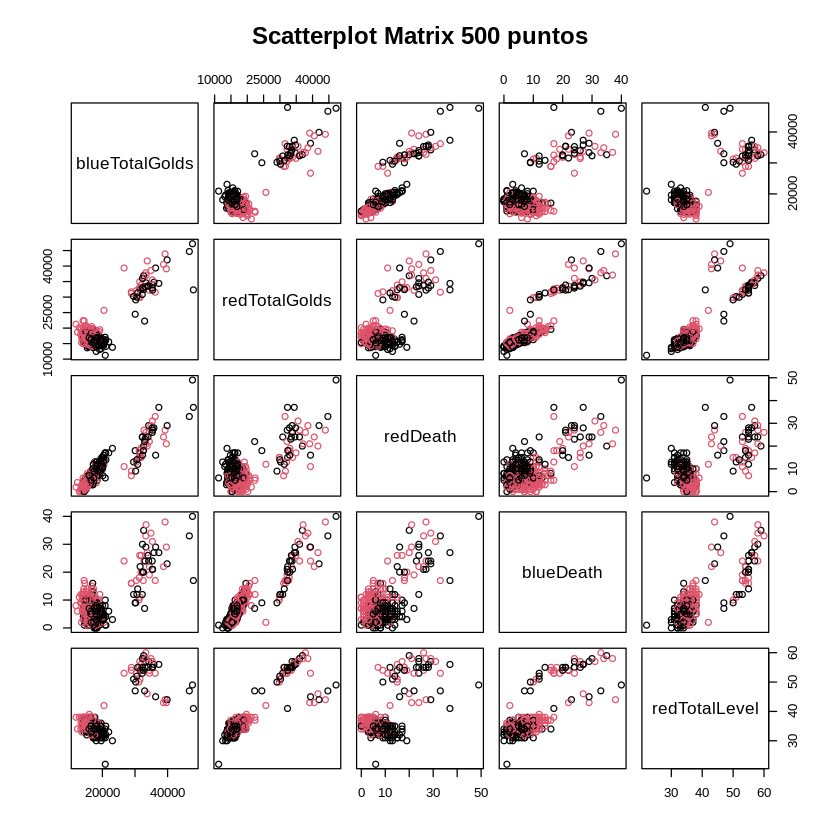

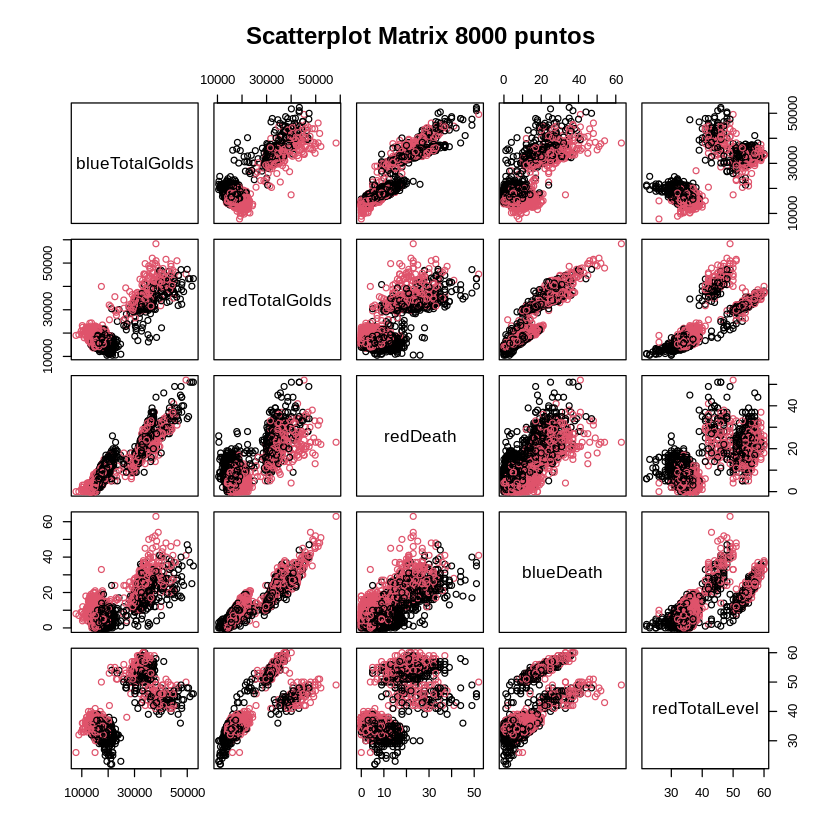

In [ ]:
pairs(data_v[, c(1, 22, 29, 8, 24)], col=as.numeric(as.factor(class_v)), pch = 1, main = "Scatterplot Matrix 500 puntos")
pairs(data[, c(1, 22, 29, 8, 24)], col=as.numeric(as.factor(class)), pch = 1, main = "Scatterplot Matrix 8000 puntos")

Como ya habiamos visto, el oro de cada equipo parece ser la mejor para separar y los métodos se seleccion de variables lo confirman. También se puede ver un resultado parecido con la relación entre las muertes de ambos equipos.

### PCA

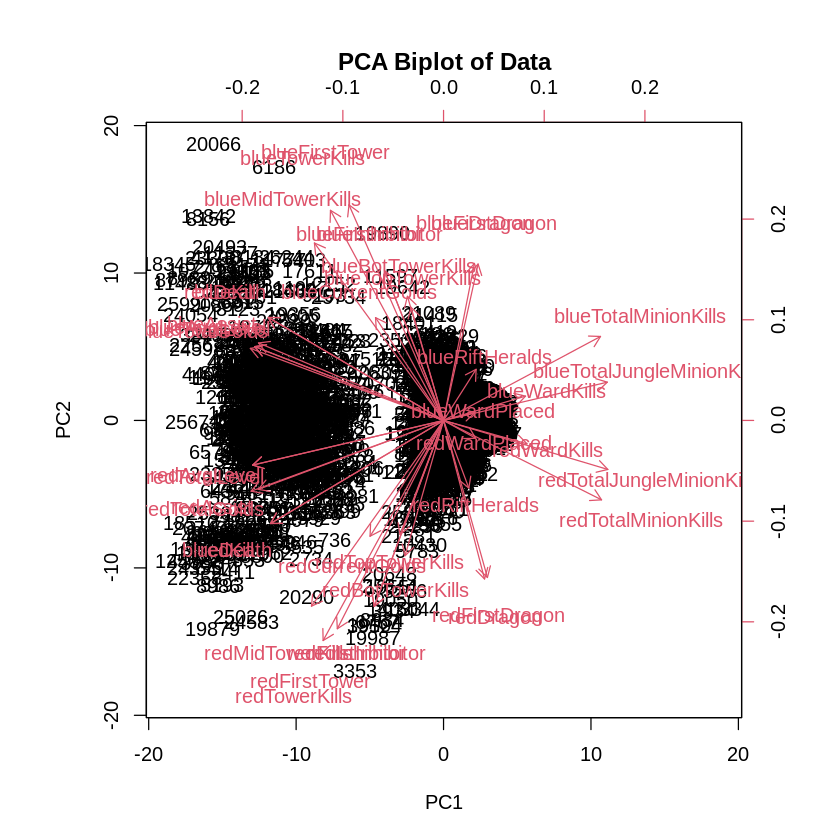

In [ ]:
pca_data <- prcomp(data, center = TRUE, scale. = TRUE)
biplot(pca_data, scale = 0,
       main = "PCA Biplot of Data")

No considero que haya puntos que esten tan alejados del resto como para ser tomados como outliers, en especial teniendo en cuenta que solo estamos mirando 8000 puntos de los mas de 26000 que tenemos, estos puntos un poco alejados (como el 20066) puede que sean raros en la distribución completa pero no tan raros para ser considerados outliers.

Podemos ver multiples correlaciones entre las variables, algunas son:


*   blueKill y redDeath: Tiene sentido ya que las muertes de un equipo suelen ser los asesinatos del otro
*   redKill y blueDeath: Idem al punto anterior
*   totalLevel y avgLevel: el avgLevel es el totalLevel dividido por 5
*   firstDragon y Dragons: normalmente a los 10 minutos de partida solo se mató a un único dragon, por lo que el equipo que mato el primero mato a ese único, habiendo una correlación


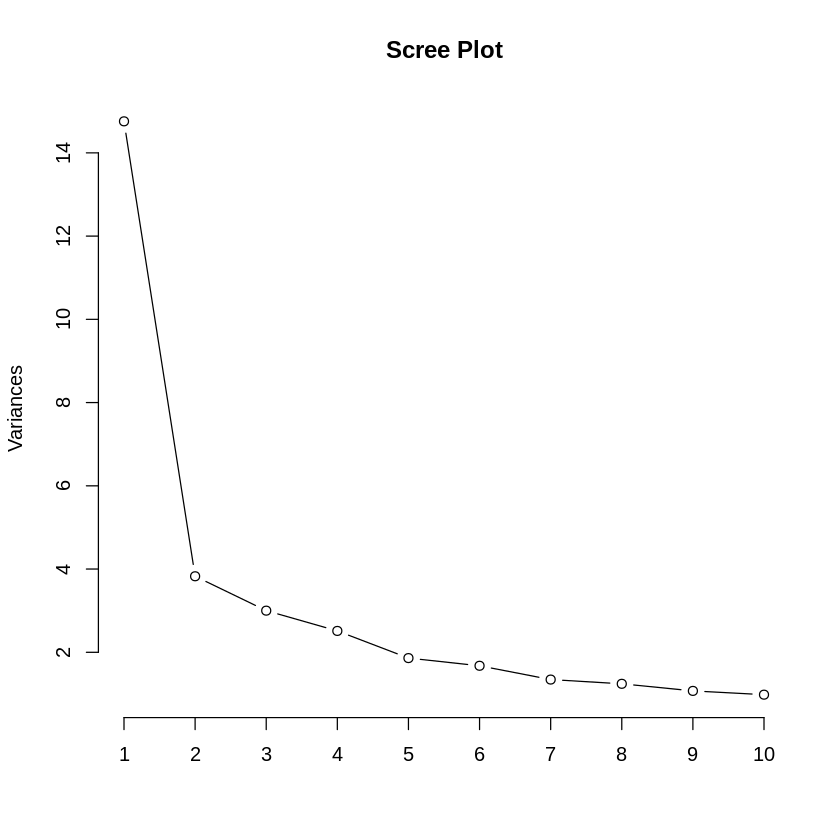

In [ ]:
screeplot(pca_data, type = "lines", main = "Scree Plot")

Es muy claro como la primer dimensión de la PCA tiene mucha varianza y como con las primeras 5 dimensiones mantenemos la mayor parte de la varianza de la distribución.

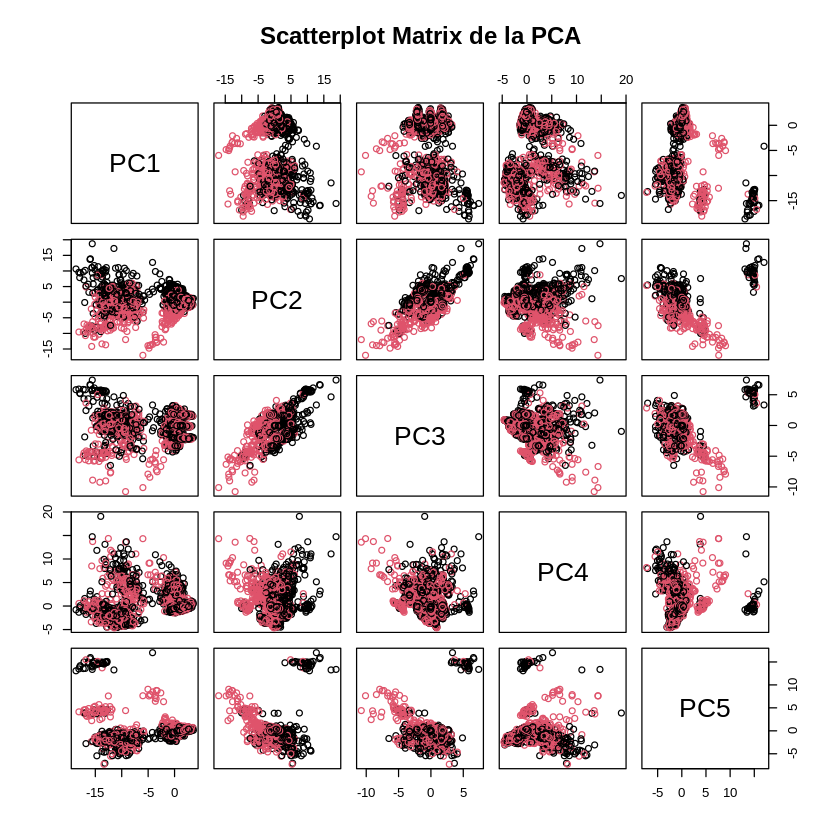

In [ ]:
pairs(pca_data$x[, 1:5], col=as.numeric(as.factor(class)), pch = 1, main = "Scatterplot Matrix de la PCA")

Se puede ver en este gráfico que la segunda dimensión de la PCA parece ser la que logra diferenciar mejor que equipo gana.

### Chernoff Faces

Siempre me pareció particular esta forma de ver los datos por lo que decidí hacer algunas pruebas con unas pocas caras y con las variables importantes determinadas por los métodos de seleccion de variables.

Usemos las 10 features mas importantes segun RFE con random forest

1.   blueTotalGolds
2.   redTotalGolds
3.   redDeath
1.   blueDeath
2.   redTotalLevel
3.   blueTotalLevel
1.   redAssist
2.   blueAssist
3.   blueKill
1.   blueTotalMinionKills

In [ ]:
index_chernoff <- sample(nrow(data), 16)
data[index_chernoff,c(1, 22, 29, 8, 24, 3, 30, 9, 7, 5)]

blueTotalGolds redTotalGolds redDeath blueDeath redTotalLevel
3183  15981          17358          4        6        36           
16604 15686          15591          1        1        37           
10677 16091          17096          6        5        34           
21901 15976          14449          4        4        32           
16753 17132          16892          7        8        36           
21839 17647          15573          9        4        33           
8382  18518          13575          7        5        27           
545   34972          33675         28       26        56           
18847 16496          17841          6       11        37           
18689 15866          14536          5        3        35           
489   16144          16085          6        7        35           
1772  15549          15662          3        3        36           
10264 20124          18786         12       11        37           
2616  30344          31197         17       16        54           
4500  31525          32741         14       19        54           
1684  18783          14934          9        4        32           
      blueTotalLevel redAssist blueAssist blueKill blueTotalMinionKills
3183  35              6         4          4       252                 
16604 37              1         1          1       252                 
10677 33              4        14          6       202                 
21901 34              6         7          4       245                 
16753 34              6         7          7       236                 
21839 35              4        14          9       230                 
8382  35              1         6          7       215                 
545   58             63        63         28       113                 
18847 36              6         8          6       204                 
18689 35              1         4          5       225                 
489   35              7         8          6       202                 
1772  35              2         4          3       210                 
10264 36             12        14         12       213                 
2616  52             48        49         17       101                 
4500  52             47        24         14       119                 
1684  37              6        12          9       246

In [ ]:
class[index_chernoff]

[1] red  blue red  red  red  blue blue red  blue blue red  blue red  red  red 
[16] red 
Levels: blue red

effect of variables:
 modified item       Var                   
 "height of face   " "blueTotalGolds"      
 "width of face    " "redTotalGolds"       
 "structure of face" "redDeath"            
 "height of mouth  " "blueDeath"           
 "width of mouth   " "redTotalLevel"       
 "smiling          " "blueTotalLevel"      
 "height of eyes   " "redAssist"           
 "width of eyes    " "blueAssist"          
 "height of hair   " "blueKill"            
 "width of hair   "  "blueTotalMinionKills"
 "style of hair   "  "blueTotalGolds"      
 "height of nose  "  "redTotalGolds"       
 "width of nose   "  "redDeath"            
 "width of ear    "  "blueDeath"           
 "height of ear   "  "redTotalLevel"       


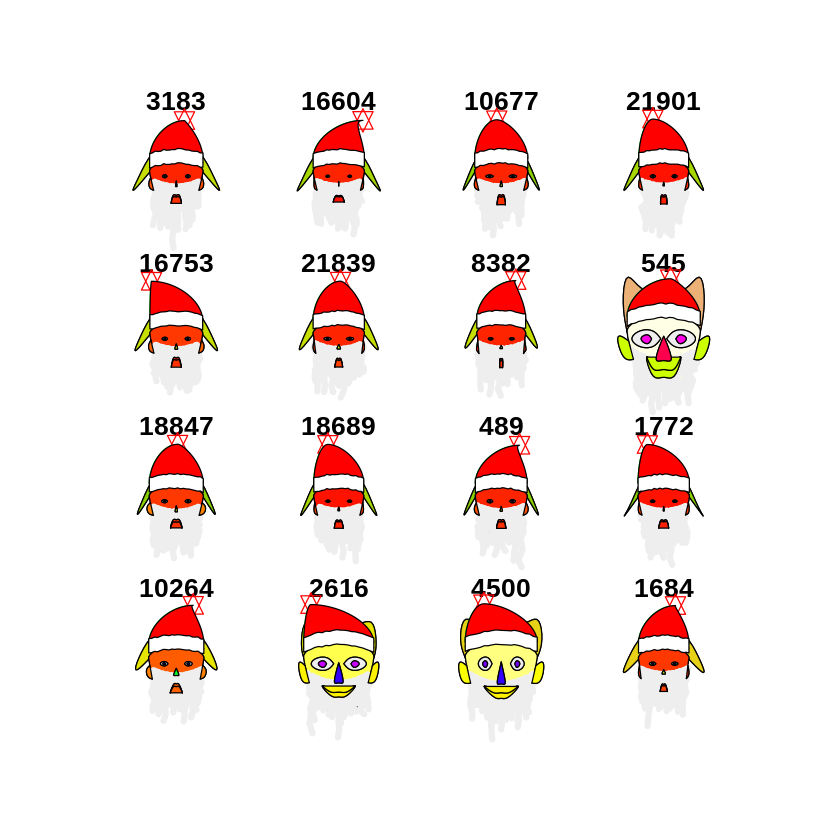

In [ ]:
faces(data[index_chernoff,c(1, 22, 29, 8, 24, 3, 30, 9, 7, 5)],face.type=2)

Podemos ver que la mayoría de las caras son parecidas, pero hay en particular tres que son muy distintas, mirando los valores de cada variable que tomaron estos samples podemos ver que los valores de las muertes, las asistencias, el nivel y el oro son mucho mayores en estos samples que en los otros.

(Las caras  on navideñas por la época del año)

Un comentario luego de haber hecho el análisis de los dos clusters:

Claramente estas caras coinciden con lo que encontramos al buscar dos clsuters, donde diferencian las partidas donde se jugo de forma más pacifica y las partidas donde jugaron de forma agresiva centrandose en los asesinatos.

# Variables relevantes

## Wrapper Greedy Forward

### Random Forest

In [ ]:
cat("Wrapper Greedy Forward Random Forest\n\n")
DA.FORW.rf <- forward.ranking(data, class,method="rf.est", verbosity=0)
importance <- colnames(data)[DA.FORW.rf]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}


Wrapper Greedy Forward Random Forest

Puesto 1 : blueTotalLevel 
Puesto 2 : redTotalGolds 
Puesto 3 : blueTotalGolds 
Puesto 4 : redInhibitor 
Puesto 5 : redDragon 
Puesto 6 : redTowerKills 
Puesto 7 : redKill 
Puesto 8 : blueFirstTower 
Puesto 9 : blueFirstDragon 
Puesto 10 : redFirstDragon 
Puesto 11 : redBotTowerKills 
Puesto 12 : redTopTowerKills 
Puesto 13 : blueCurrentGolds 
Puesto 14 : redFirstInhibitor 
Puesto 15 : redAvgLevel 
Puesto 16 : blueFirstInhibitor 
Puesto 17 : redAssist 
Puesto 18 : blueDragon 
Puesto 19 : redTotalMinionKills 
Puesto 20 : blueAvgLevel 
Puesto 21 : blueTopTowerKills 
Puesto 22 : redMidTowerKills 
Puesto 23 : blueBotTowerKills 
Puesto 24 : blueTotalMinionKills 
Puesto 25 : blueWardKills 
Puesto 26 : blueWardPlaced 
Puesto 27 : blueInhibitor 
Puesto 28 : redRiftHeralds 
Puesto 29 : blueDeath 
Puesto 30 : redFirstTower 
Puesto 31 : redCurrentGolds 
Puesto 32 : redTotalJungleMinionKills 
Puesto 33 : blueRiftHeralds 
Puesto 34 : redDeath 
Puesto 35 : redWa

### LDA

In [ ]:
cat("Wrapper Greedy Forward LDA\n\n")
DA.FORW.lda <- forward.ranking(data, class,method="lda.est", verbosity=0)
importance <- colnames(data)[DA.FORW.lda]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Wrapper Greedy Forward LDA

Puesto 1 : blueTotalLevel 
Puesto 2 : redTotalLevel 
Puesto 3 : redDragon 
Puesto 4 : blueDeath 
Puesto 5 : blueTotalGolds 
Puesto 6 : redTotalGolds 
Puesto 7 : blueFirstDragon 
Puesto 8 : blueCurrentGolds 
Puesto 9 : blueFirstInhibitor 
Puesto 10 : blueAvgLevel 
Puesto 11 : redKill 
Puesto 12 : blueDragon 
Puesto 13 : redAvgLevel 
Puesto 14 : blueInhibitor 
Puesto 15 : redFirstDragon 
Puesto 16 : redTopTowerKills 
Puesto 17 : redTotalJungleMinionKills 
Puesto 18 : redCurrentGolds 
Puesto 19 : redFirstTower 
Puesto 20 : redAssist 
Puesto 21 : redFirstInhibitor 
Puesto 22 : redInhibitor 
Puesto 23 : blueWardKills 
Puesto 24 : blueTopTowerKills 
Puesto 25 : blueTowerKills 
Puesto 26 : redBotTowerKills 
Puesto 27 : blueMidTowerKills 
Puesto 28 : redTotalMinionKills 
Puesto 29 : blueBotTowerKills 
Puesto 30 : redWardKills 
Puesto 31 : blueWardPlaced 
Puesto 32 : blueAssist 
Puesto 33 : blueFirstTower 
Puesto 34 : blueKill 
Puesto 35 : redDeath 
Puesto 36 : blueR

### SVM

In [ ]:
cat("Wrapper Greedy Forward SVM\n\n")
DA.FORW.svm <- forward.ranking(data, class,method="svm.est", verbosity=0)
importance <- colnames(data)[DA.FORW.svm]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Wrapper Greedy Forward SVM

Puesto 1 : blueKill 
Puesto 2 : blueDeath 
Puesto 3 : blueFirstDragon 
Puesto 4 : redTotalMinionKills 
Puesto 5 : blueTotalMinionKills 
Puesto 6 : redTotalJungleMinionKills 
Puesto 7 : redTotalLevel 
Puesto 8 : blueAvgLevel 
Puesto 9 : redInhibitor 
Puesto 10 : redTowerKills 
Puesto 11 : blueInhibitor 
Puesto 12 : redAvgLevel 
Puesto 13 : redAssist 
Puesto 14 : redBotTowerKills 
Puesto 15 : redCurrentGolds 
Puesto 16 : blueCurrentGolds 
Puesto 17 : redFirstInhibitor 
Puesto 18 : redKill 
Puesto 19 : blueTotalGolds 
Puesto 20 : redTotalGolds 
Puesto 21 : blueWardKills 
Puesto 22 : blueTotalJungleMinionKills 
Puesto 23 : redFirstTower 
Puesto 24 : blueTopTowerKills 
Puesto 25 : redTopTowerKills 
Puesto 26 : redWardKills 
Puesto 27 : redWardPlaced 
Puesto 28 : redDeath 
Puesto 29 : blueTowerKills 
Puesto 30 : redFirstDragon 
Puesto 31 : blueRiftHeralds 
Puesto 32 : blueFirstInhibitor 
Puesto 33 : blueMidTowerKills 
Puesto 34 : blueBotTowerKills 
Puesto 35 : blu

## Wrapper Greedy Backward

### Random Forest

In [ ]:
cat("Wrapper Greedy Backward Random Forest\n\n")
DA.BACK.rf <- backward.ranking(data, class,method="rf.est", verbosity=0)
importance <- colnames(data)[DA.BACK.rf]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Wrapper Greedy Backward Random Forest

Puesto 1 : redTotalGolds 
Puesto 2 : blueTotalGolds 
Puesto 3 : blueFirstDragon 
Puesto 4 : redTopTowerKills 
Puesto 5 : blueFirstInhibitor 
Puesto 6 : redAssist 
Puesto 7 : blueTotalJungleMinionKills 
Puesto 8 : blueDragon 
Puesto 9 : redDragon 
Puesto 10 : blueAssist 
Puesto 11 : redCurrentGolds 
Puesto 12 : blueAvgLevel 
Puesto 13 : redAvgLevel 
Puesto 14 : blueWardPlaced 
Puesto 15 : blueBotTowerKills 
Puesto 16 : blueRiftHeralds 
Puesto 17 : blueTotalMinionKills 
Puesto 18 : blueKill 
Puesto 19 : redFirstInhibitor 
Puesto 20 : redWardKills 
Puesto 21 : redFirstDragon 
Puesto 22 : blueTotalLevel 
Puesto 23 : blueTowerKills 
Puesto 24 : blueCurrentGolds 
Puesto 25 : blueTopTowerKills 
Puesto 26 : blueFirstTower 
Puesto 27 : blueMidTowerKills 
Puesto 28 : redWardPlaced 
Puesto 29 : redTowerKills 
Puesto 30 : redDeath 
Puesto 31 : blueDeath 
Puesto 32 : redRiftHeralds 
Puesto 33 : redTotalJungleMinionKills 
Puesto 34 : blueInhibitor 
Puesto 35 : 

### LDA

In [ ]:
cat("Wrapper Greedy Backward LDA\n\n")
DA.BACK.lda <- backward.ranking(data, class,method="lda.est", verbosity=0)
importance <- colnames(data)[DA.BACK.lda]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Wrapper Greedy Backward LDA

Puesto 1 : blueTotalGolds 
Puesto 2 : redTotalGolds 
Puesto 3 : blueDragon 
Puesto 4 : redAvgLevel 
Puesto 5 : blueWardPlaced 
Puesto 6 : redTotalJungleMinionKills 
Puesto 7 : blueAvgLevel 
Puesto 8 : redTopTowerKills 
Puesto 9 : redCurrentGolds 
Puesto 10 : blueMidTowerKills 
Puesto 11 : redFirstTower 
Puesto 12 : redMidTowerKills 
Puesto 13 : redBotTowerKills 
Puesto 14 : blueBotTowerKills 
Puesto 15 : redKill 
Puesto 16 : blueTopTowerKills 
Puesto 17 : blueCurrentGolds 
Puesto 18 : blueTotalMinionKills 
Puesto 19 : redInhibitor 
Puesto 20 : blueFirstTower 
Puesto 21 : redWardPlaced 
Puesto 22 : redFirstDragon 
Puesto 23 : blueWardKills 
Puesto 24 : redTowerKills 
Puesto 25 : redFirstInhibitor 
Puesto 26 : redTotalLevel 
Puesto 27 : blueTowerKills 
Puesto 28 : redTotalMinionKills 
Puesto 29 : redWardKills 
Puesto 30 : blueInhibitor 
Puesto 31 : blueFirstInhibitor 
Puesto 32 : blueDeath 
Puesto 33 : blueRiftHeralds 
Puesto 34 : blueTotalJungleMinionKills 


### SVM

In [ ]:
cat("Wrapper Greedy Backward SVM\n\n")
DA.BACK.svm <- backward.ranking(data,class,method="svm.est", verbosity=0)
importance <- colnames(data)[DA.BACK.svm]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Wrapper Greedy Backward SVM

Puesto 1 : redTotalGolds 
Puesto 2 : blueTotalGolds 
Puesto 3 : redDragon 
Puesto 4 : redMidTowerKills 
Puesto 5 : redTowerKills 
Puesto 6 : redDeath 
Puesto 7 : blueAvgLevel 
Puesto 8 : blueInhibitor 
Puesto 9 : blueTotalJungleMinionKills 
Puesto 10 : blueTowerKills 
Puesto 11 : blueTotalMinionKills 
Puesto 12 : blueDeath 
Puesto 13 : blueKill 
Puesto 14 : redFirstTower 
Puesto 15 : redFirstDragon 
Puesto 16 : redTotalMinionKills 
Puesto 17 : redTotalJungleMinionKills 
Puesto 18 : redAssist 
Puesto 19 : blueTotalLevel 
Puesto 20 : blueBotTowerKills 
Puesto 21 : redBotTowerKills 
Puesto 22 : blueFirstTower 
Puesto 23 : blueWardKills 
Puesto 24 : blueFirstDragon 
Puesto 25 : redTopTowerKills 
Puesto 26 : redWardKills 
Puesto 27 : redWardPlaced 
Puesto 28 : blueMidTowerKills 
Puesto 29 : redInhibitor 
Puesto 30 : blueRiftHeralds 
Puesto 31 : redTotalLevel 
Puesto 32 : blueDragon 
Puesto 33 : redRiftHeralds 
Puesto 34 : redCurrentGolds 
Puesto 35 : blueFirstIn

## Kruskal-Wallis

In [ ]:
cat("Kruskal-Wallis\n\n")
DA.KRUS <- kruskal.ranking(data, class, verbosity=0)
importance <- colnames(data)[DA.KRUS]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

Kruskal-Wallis

Puesto 1 : redTotalGolds 
Puesto 2 : blueTotalGolds 
Puesto 3 : blueTotalLevel 
Puesto 4 : blueAvgLevel 
Puesto 5 : redTotalLevel 
Puesto 6 : redAvgLevel 
Puesto 7 : blueDeath 
Puesto 8 : redKill 
Puesto 9 : blueKill 
Puesto 10 : redDeath 
Puesto 11 : redAssist 
Puesto 12 : blueAssist 
Puesto 13 : blueTotalMinionKills 
Puesto 14 : redDragon 
Puesto 15 : redFirstDragon 
Puesto 16 : blueDragon 
Puesto 17 : blueFirstDragon 
Puesto 18 : redTotalMinionKills 
Puesto 19 : redCurrentGolds 
Puesto 20 : blueCurrentGolds 
Puesto 21 : blueFirstTower 
Puesto 22 : blueTotalJungleMinionKills 
Puesto 23 : redFirstTower 
Puesto 24 : redTotalJungleMinionKills 
Puesto 25 : blueTowerKills 
Puesto 26 : blueRiftHeralds 
Puesto 27 : redTowerKills 
Puesto 28 : redRiftHeralds 
Puesto 29 : blueBotTowerKills 
Puesto 30 : redMidTowerKills 
Puesto 31 : blueMidTowerKills 
Puesto 32 : redFirstInhibitor 
Puesto 33 : redInhibitor 
Puesto 34 : redBotTowerKills 
Puesto 35 : blueWardKills 
Puesto 36 : blu

## RFE

### Random Forest

In [ ]:
cat("RFE Random Forest\n\n")
DA.RFE.rf <- rfe.ranking(data, class,method="imp.rf", verbosity=0)
importance <- colnames(data)[DA.RFE.rf]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

RFE Random Forest

Puesto 1 : blueTotalGolds 
Puesto 2 : redTotalGolds 
Puesto 3 : redDeath 
Puesto 4 : blueDeath 
Puesto 5 : redTotalLevel 
Puesto 6 : blueTotalLevel 
Puesto 7 : redAssist 
Puesto 8 : blueAssist 
Puesto 9 : blueKill 
Puesto 10 : blueTotalMinionKills 
Puesto 11 : redKill 
Puesto 12 : redAvgLevel 
Puesto 13 : blueAvgLevel 
Puesto 14 : redTotalMinionKills 
Puesto 15 : blueDragon 
Puesto 16 : redTotalJungleMinionKills 
Puesto 17 : blueTotalJungleMinionKills 
Puesto 18 : redFirstTower 
Puesto 19 : redFirstDragon 
Puesto 20 : blueFirstTower 
Puesto 21 : redTowerKills 
Puesto 22 : blueFirstDragon 
Puesto 23 : redDragon 
Puesto 24 : blueTowerKills 
Puesto 25 : blueMidTowerKills 
Puesto 26 : redCurrentGolds 
Puesto 27 : redInhibitor 
Puesto 28 : blueWardPlaced 
Puesto 29 : blueFirstInhibitor 
Puesto 30 : redFirstInhibitor 
Puesto 31 : blueCurrentGolds 
Puesto 32 : redWardPlaced 
Puesto 33 : blueInhibitor 
Puesto 34 : redWardKills 
Puesto 35 : blueWardKills 
Puesto 36 : redMidTo

### SVM

Para RFE con SVM voy a usar los datos escalados debido a que las diferencias de escalas entre las distintas variables afectan a los componentes del vector que define el hiperplano que separa los datos, cambiando asi mucho la importancia que se le da a cada componente.

In [ ]:
scaled_data <- scale(data)

In [ ]:
cat("RFE SVM\n\n")
DA.RFE.svm <- rfe.ranking(scaled_data, class,method="imp.linsvm", verbosity=0)
importance <- colnames(scaled_data)[DA.RFE.svm]

for (i in 1:length(importance)) {
  cat("Puesto", i, ":", importance[i],"\n")
}

RFE SVM

Puesto 1 : redTotalGolds 
Puesto 2 : blueTotalGolds 
Puesto 3 : blueAvgLevel 
Puesto 4 : redTotalLevel 
Puesto 5 : blueTotalLevel 
Puesto 6 : redAvgLevel 
Puesto 7 : redFirstDragon 
Puesto 8 : redBotTowerKills 
Puesto 9 : blueTowerKills 
Puesto 10 : blueDragon 
Puesto 11 : redTotalJungleMinionKills 
Puesto 12 : redTopTowerKills 
Puesto 13 : redFirstTower 
Puesto 14 : redCurrentGolds 
Puesto 15 : redTowerKills 
Puesto 16 : blueAssist 
Puesto 17 : redDragon 
Puesto 18 : redDeath 
Puesto 19 : blueFirstTower 
Puesto 20 : blueTopTowerKills 
Puesto 21 : blueBotTowerKills 
Puesto 22 : blueMidTowerKills 
Puesto 23 : blueInhibitor 
Puesto 24 : blueKill 
Puesto 25 : blueTotalMinionKills 
Puesto 26 : blueWardPlaced 
Puesto 27 : blueCurrentGolds 
Puesto 28 : blueTotalJungleMinionKills 
Puesto 29 : redWardPlaced 
Puesto 30 : blueFirstInhibitor 
Puesto 31 : blueFirstDragon 
Puesto 32 : redRiftHeralds 
Puesto 33 : redInhibitor 
Puesto 34 : redKill 
Puesto 35 : blueDeath 
Puesto 36 : redTotal

## Análisis
Casi todos los métodos determinaron que redTotalGolds y blueTotalGolds son las variables mas importantes y en especial todos los métodos RFE, Wrapper backward y el test no paramétrico las tuvieron como las dos variables más importantes.

Las otras variables muy elegidas son blueAvgLevel, blueTotalLevel y redTotalLevel. Existe una correlación muy fuerte entre el nivel promedio y el total, por lo que podemos deducir que el nivel es importante.

Lo que podemos sacar de los métodos es que el nivel y el oro parecen ser las variables mas importantes. Esto tiene sentido ya que son los principales indicadores de ventaja.

Me parece interesante agregar que las principales 6 variables determinadas por RFE con SVM son:
*   redTotalGolds
*   blueTotalGolds
*   blueAvgLevel
*   redTotalLevel
*   blueTotalLevel
*   redAvgLevel

Estas son literalmente todas las variables que hacen referencia a oro total o niveles (es importante destacar esto ya que luego de correr la parte de clasificación vimos que SVM fue el método que obtuvo mejores resultados).

También vale la pena mencionar algunas variables que ningún método tuvo entre las 10 mas importantes, algunas incluso no llegaron ni al top 20 de ningún método:

*   redWardKills
*   redFirstInhibitor
*   blueWardKills
*   blueRiftHeralds
*   redRiftHeralds
*   redWardPlaced
*   blueBotTowerKills
*   blueTopTowerKills
*   redFirstTower

Estas coinciden con las cosas que menos suelen importar en las partidas como la cantidad de wards que se pusieron o destruyeron.

De todas formas, decidí no sacar variables ya que las evaluaciones que hicimos con SVM usaron kernels lineales, los que voy a probar en clasificación son RBF y polinomial, por lo que yo no puedo estar seguro que esas variables no van a aportar información cuando se utilizan otros kernels. Lo mismo se puede decir con XGBoost, como no hicimos ningun método de selección con ese clasificador no podemos estar seguros de que no importen esas variables.

# Clustering

Para los análisis de clustering vamos a utilizar las siguientes versiones de los datos:

1.   Datos base
6.   Escalado
7.   Escalado + PCA
8.   Escalado + PCA + Escalado
9.   PCA
10.  PCA + Escalado

In [ ]:
data_scaled <- scale(data)
data_scaled_pca <- prcomp(data_scaled)
data_scaled_pca_scaled <- scale(data_scaled_pca$x)
data_pca <- prcomp(data)
data_pca_scaled <- scale(data_pca$x)

## Busqueda de dos clusters

Para un primer análisis busquemos dos clusters para ver si logramos agrupar según quien ganó cada partida.


### K-Means

In [ ]:
centers = 2
kmeans_k2_data <- kmeans(data, centers=centers, nstart = 20)
kmeans_k2_data_scaled <- kmeans(data_scaled, centers=centers, nstart = 20)
kmeans_k2_data_scaled_pca <- kmeans(data_scaled_pca$x, centers=centers, nstart = 20)
kmeans_k2_data_scaled_pca_scaled <- kmeans(data_scaled_pca_scaled, centers=centers, nstart = 20)
kmeans_k2_data_pca <- kmeans(data_pca$x, centers=centers, nstart = 20)
kmeans_k2_data_pca_scaled <- kmeans(data_pca_scaled, centers=centers, nstart = 20)

In [ ]:
cat("------- Datos Base -------\n")
compare_clusters(class, kmeans_k2_data$cluster)
cat("\n\n------- Escalado -------\n")
compare_clusters(class, kmeans_k2_data_scaled$cluster)
cat("\n\n------- Escalado + PCA -------\n")
compare_clusters(class, kmeans_k2_data_scaled_pca$cluster)
cat("\n\n------- Escalado + PCA + Escalado-------\n")
compare_clusters(class, kmeans_k2_data_scaled_pca_scaled$cluster)
cat("\n\n------- PCA -------\n")
compare_clusters(class, kmeans_k2_data_pca$cluster)
cat("\n\n------- PCA + Escalado -------\n")
compare_clusters(class, kmeans_k2_data_pca_scaled$cluster)

------- Datos Base -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.74 %
      cluster_result
class     1    2
  blue 3675  378
  red  3563  384


------- Escalado -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.73 %
      cluster_result
class     2    1
  blue 3670  383
  red  3559  388


------- Escalado + PCA -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.73 %
      cluster_result
class     1    2
  blue 3670  383
  red  3559  388


------- Escalado + PCA + Escalado-------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.71 %
      cluster_result
class     2    1
  blue 3671  382
  red  3561  386


------- PCA -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.74 %
      cluster_result
class     2    1
  blue 

Miremos como se ve en las primeras dimensiones de la PCA la clase y lo que obtuvimos al buscar los dos clusters:

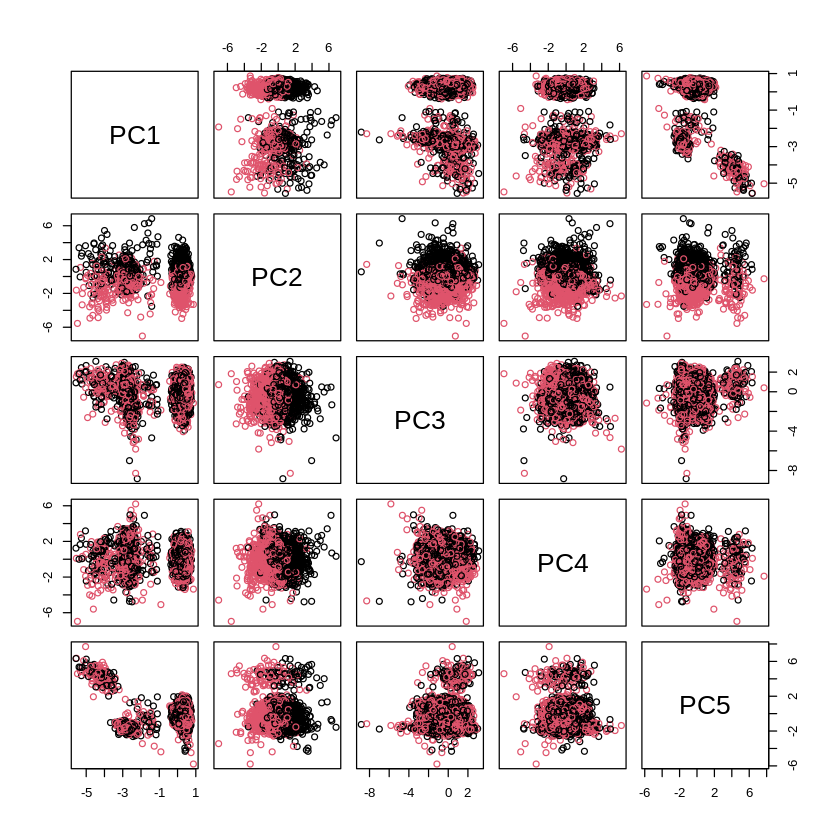

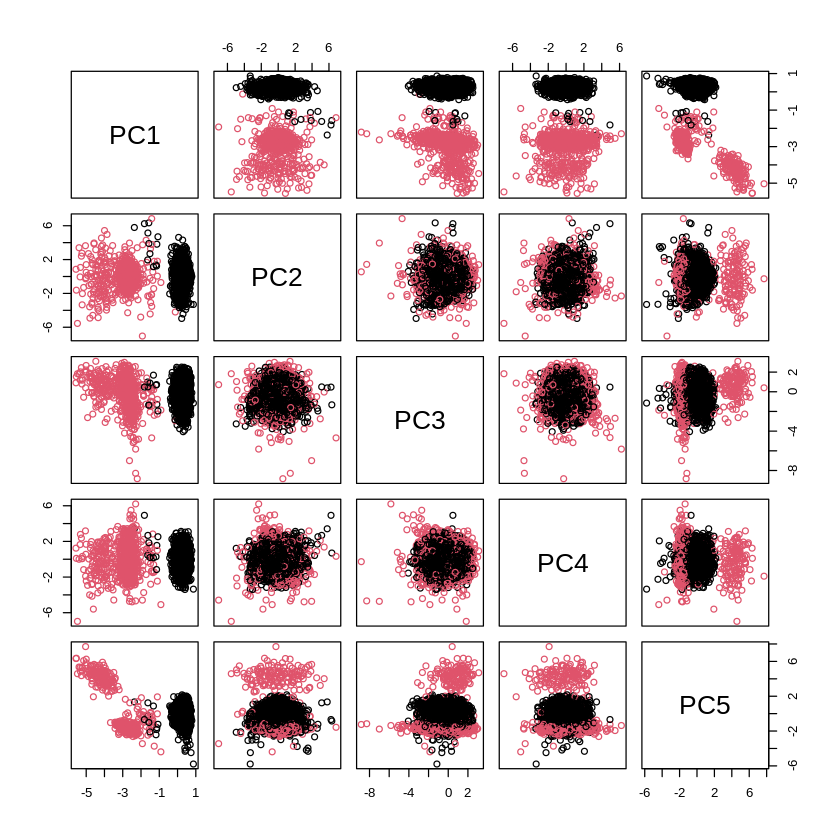

In [ ]:
pairs(data_pca_scaled[, 1:5], col=as.numeric(as.factor(class)))
pairs(data_pca_scaled[, 1:5], col=as.numeric(as.factor(kmeans_k2_data_pca_scaled$cluster)))

Me gustaría analizar dos cosas, la primera es que fueron los dos clusters encostrados por K-Means en la PCA y la segunda es que sucede cuando buscamos dos clusters pero solo mirando la segunda dimension de la PCA.

#### Análisis clusters obtenidos

Si miramos la PC1 y la PC2 podemos ver claramente cuales son los dos clusters que se encontró, pero estos no coinciden para nada con quien ganó cada partida, por lo que me gustaria hacer algun análisis de los datos para ver si encuentro las diferencias que separan tanto estos dos grupos.

In [ ]:
cluster1 <- data[kmeans_k2_data_pca_scaled$cluster == 1, ]
cluster2 <- data[kmeans_k2_data_pca_scaled$cluster == 2, ]

In [ ]:
summary_cluster1 <- lapply(cluster1, summary)
summary_cluster2 <- lapply(cluster2, summary)

# Comparar resúmenes
for (var in names(summary_cluster1)) {
  cat("Variable:", var, "\n")
  cat("Cluster 1:\n")
  print(summary_cluster1[[var]])
  cat("Cluster 2:\n")
  print(summary_cluster2[[var]])
  cat("\n")
}


Variable: blueTotalGolds 
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7792   15464   16427   16569   17493   40248 
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13058   31742   33384   34200   35357   52333 

Variable: blueCurrentGolds 
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     38    2171    2876    3000    3716    8297 
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    723    2943    4084    4453    5479   16248 

Variable: blueTotalLevel 
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   34.00   35.00   34.61   36.00   58.00 
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  29.00   51.00   54.00   52.47   56.00   62.00 

Variable: blueAvgLevel 
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   6.800   7.000   6.921   7.200  11.600 
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.80   10.20   10.80   10.49   11.20   12.40 

Variable: blueTotalM

Las más relevantes son:
```
Variable: blueTotalGolds
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   7792   15464   16427   16569   17493   40248
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  13058   31742   33384   34200   35357   52333

Variable: blueTotalLevel
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   8.00   34.00   35.00   34.61   36.00   58.00
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  29.00   51.00   54.00   52.47   56.00   62.00

Variable: blueTotalMinionKills
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
    1.0   208.0   224.0   221.9   239.0   288.0
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
    9.0   105.0   114.0   131.5   128.0   289.0

Variable: blueKill
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  0.000   4.000   6.000   6.172   8.000  28.000
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   2.00   17.00   22.00   22.29   27.00   52.00

Variable: blueDeath
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  0.000   4.000   6.000   6.172   8.000  21.000
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   2.00   17.00   22.00   22.86   27.00   63.00

Variable: blueAssist
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   0.00    4.00    6.00    7.17   10.00   34.00
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   0.00   31.00   44.00   45.56   59.00  121.00

Variable: redTotalGolds
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  10476   15436   16390   16536   17462   24462
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  16206   31838   33408   34493   35619   58285

Variable: redTotalLevel
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  22.00   34.00   35.00   34.65   36.00   51.00
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  36.00   51.00   54.00   52.63   56.00   60.00

Variable: redTotalMinionKills
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
     62     208     224     222     239     290
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   42.0   106.0   115.0   133.3   130.0   276.0

Variable: redKill
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  0.000   4.000   6.000   6.172   8.000  21.000
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   2.00   17.00   22.00   22.86   27.00   63.00

Variable: redDeath
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  0.000   4.000   6.000   6.172   8.000  28.000
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   2.00   17.00   22.00   22.29   27.00   52.00

Variable: redAssist
Cluster 1:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
  0.000   4.000   6.000   7.134  10.000  36.000
Cluster 2:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.
   2.00   32.00   45.00   46.23   59.00  122.00

```

Podemos ver que en estas últimas el primer quartil, la media, la mediana, el tercer cuartil y en algunas variables el máximo son completamente distintas.

El segundo cluster parece ser partidas donde hubo mucho mas asesinatos, mucho mas oro y una menor cantidad de minions asesinados. Esto debe ser debido a que son partidas donde un equipo sacó mucha ventaja muy rápido o los campeones que utilizaban eran mucho mejores con respecto a los del otro equipo, haciendo que la partida tomo un enfoque muy agresivo donde se reduce mucho la primera fase de la partida donde todos juegan mas tranquilos y se dedican a conseguir oro matando minions y pasan muy rápido a la fase donde se juega en equipo en "team-fights" donde normalmente terminan cuando todos los de un equipo mueren.
Lo que refuerza esto último es la gran cantidad de asistencias, esto significa que en estas peleas participaron muchos jugadores.






#### Análisis PC2

Como ya habiamos visto en la parte de visualización, es más diferenciable usando la segunda dimensión, por lo que usemos esta y combinaciones de esta con otras dimensiones de la PCA + Escalado para ver si logramos una mejor coincidencia.

In [ ]:
kmeans_data_pca_scaled_2 <- kmeans(data_pca_scaled[,2], centers=2, nstart = 20)
kmeans_data_pca_scaled_23 <- kmeans(data_pca_scaled[,c(2,3)], centers=2, nstart = 20)
kmeans_data_pca_scaled_24 <- kmeans(data_pca_scaled[,c(2,4)], centers=2, nstart = 20)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 400000)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 400000)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 400000)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 400000)”


In [ ]:
cat("\n\n------- Variables {2} con PCA + Escalado -------\n")
compare_clusters(class, kmeans_data_pca_scaled_2$cluster)

cat("\n\n------- Variables {2, 3} con PCA + Escalado -------\n")
compare_clusters(class, kmeans_data_pca_scaled_23$cluster)

cat("\n\n------- Variables {2, 4} con PCA + Escalado -------\n")
compare_clusters(class, kmeans_data_pca_scaled_24$cluster)



------- Variables {2} con PCA + Escalado -------
Direct agreement: 2 of 2 pairs
Cases in matched pairs: 73.06 %
      cluster_result
class     1    2
  blue 3016 1037
  red  1118 2829


------- Variables {2, 3} con PCA + Escalado -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 52.65 %
      cluster_result
class     2    1
  blue 2457 1596
  red  2192 1755


------- Variables {2, 4} con PCA + Escalado -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 57.89 %
      cluster_result
class     2    1
  blue 2376 1677
  red  1692 2255


Podemos ver que logramos un 73.06% de coincidencia usando la segunda dimensión de la PCA.

Luego de haber hecho la parte de clasificación me parece más relevante este resultado, ya que el mejor resultado que logramos fue un accuracy de 74.4375% que no está muy lejos del porcentaje de agrupamiento logrado con los dos clusters y la segunda dimensión de la PCA, lo que me da a suponer que los métodos de clasificación lo que estan logrando es encontrar esta división en los datos que tambien encontramos con K-means.

### Hclust

In [ ]:
hclust_data_average <- hclust(dist(data), method="average")
hclust_data_scaled_average <- hclust(dist(data_scaled), method="average")
hclust_data_scaled_pca_average <- hclust(dist(data_scaled_pca$x), method="average")
hclust_data_scaled_pca_scaled_average <- hclust(dist(data_scaled_pca_scaled), method="average")
hclust_data_pca_average <- hclust(dist(data_pca$x), method="average")
hclust_data_pca_scaled_average <- hclust(dist(data_pca_scaled), method="average")

In [ ]:
hclust_data_complete <- hclust(dist(data), method="complete")
hclust_data_scaled_complete <- hclust(dist(data_scaled), method="complete")
hclust_data_scaled_pca_complete <- hclust(dist(data_scaled_pca$x), method="complete")
hclust_data_scaled_pca_scaled_complete <- hclust(dist(data_scaled_pca_scaled), method="complete")
hclust_data_pca_complete <- hclust(dist(data_pca$x), method="complete")
hclust_data_pca_scaled_complete <- hclust(dist(data_pca_scaled), method="complete")

#### Average

##### Gráficas hclust

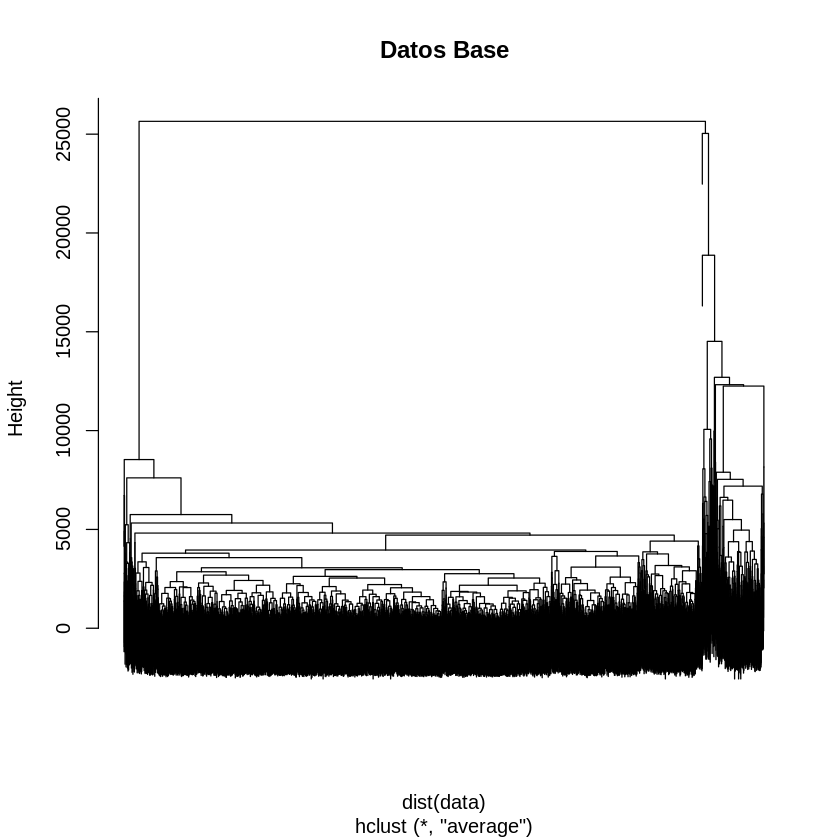

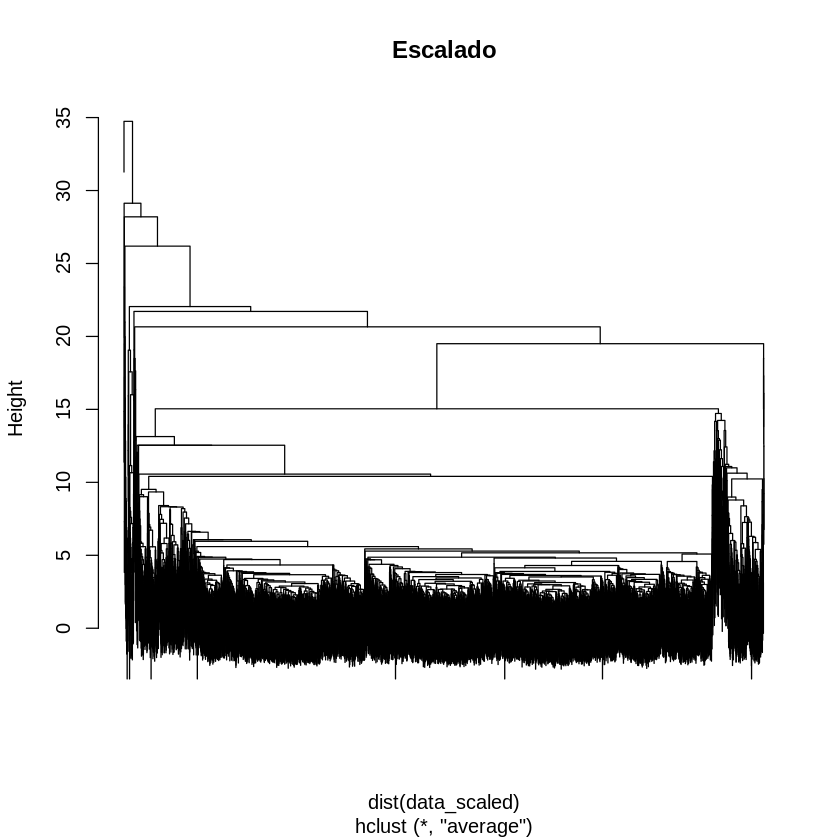

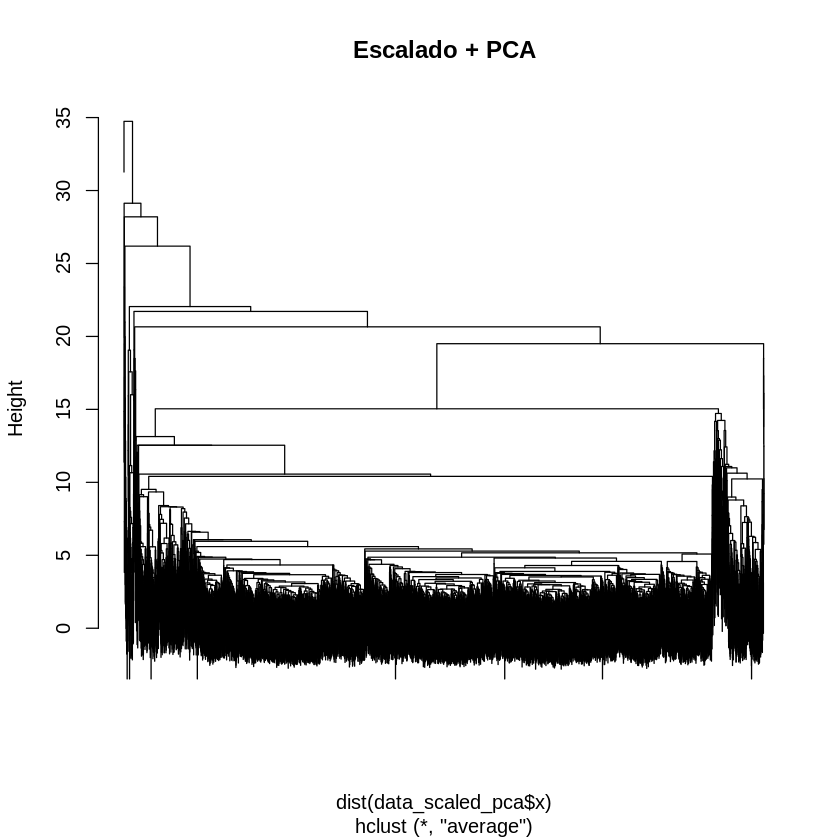

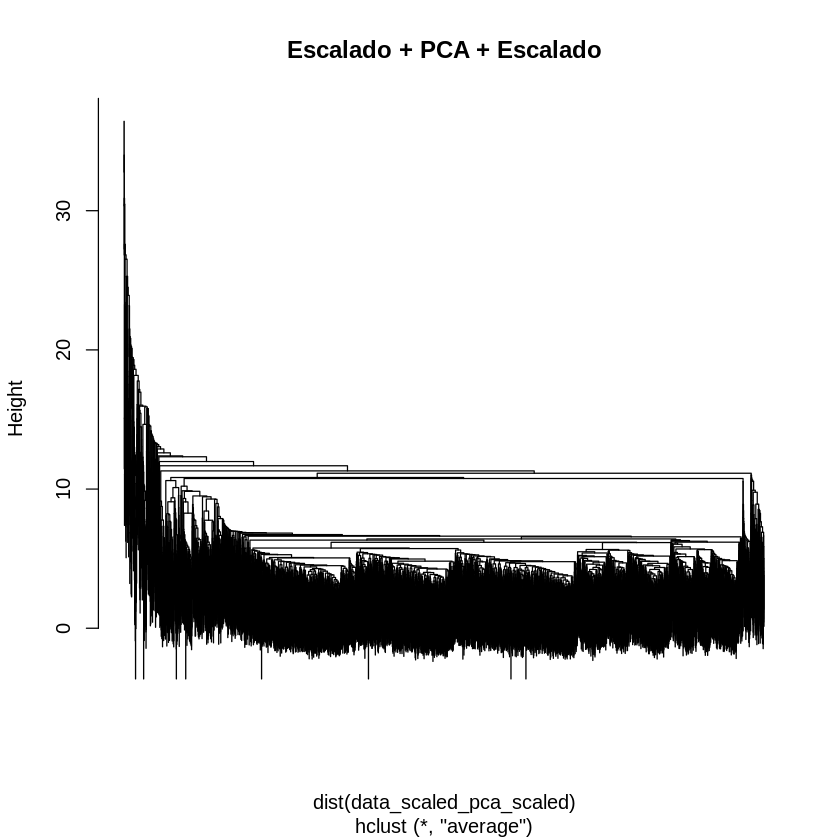

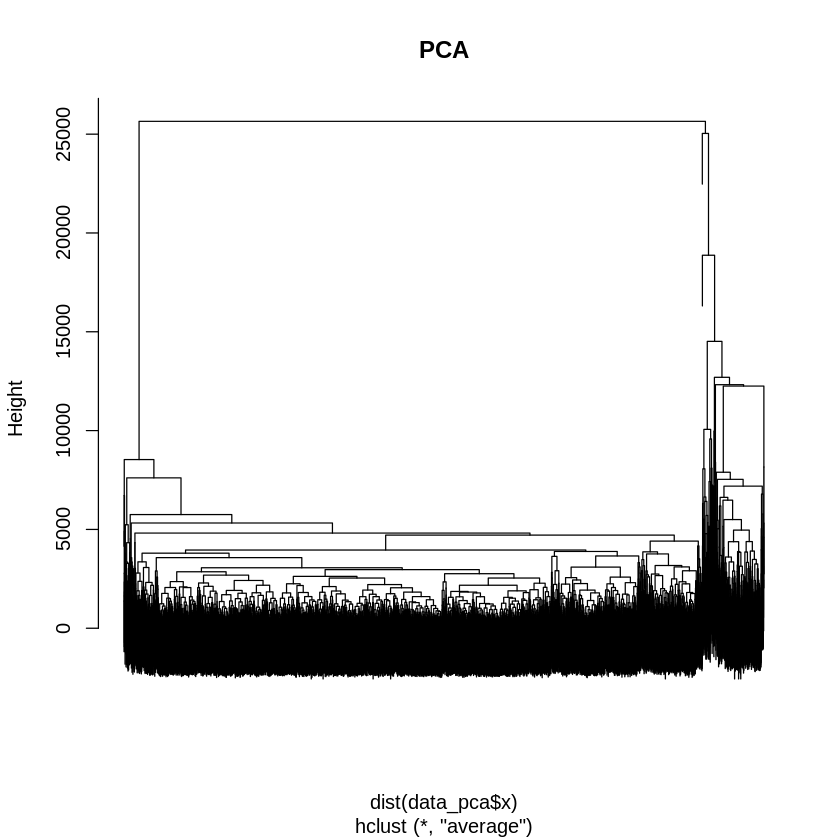

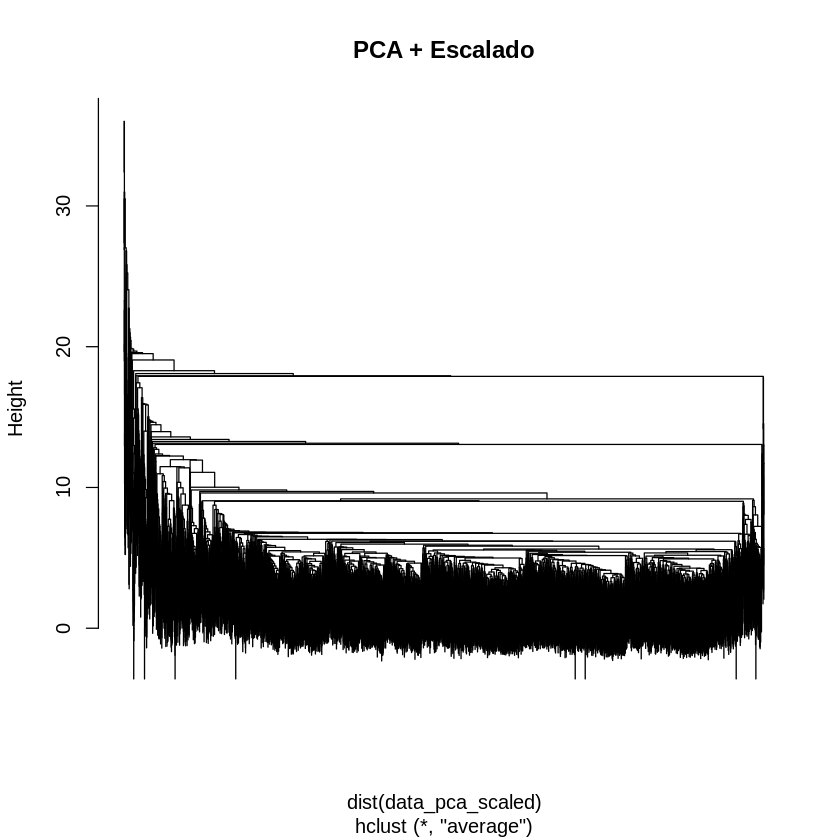

In [ ]:
plot(hclust_data_average, main="Datos Base", labels = FALSE)

plot(hclust_data_scaled_average, main="Escalado", labels = FALSE)

plot(hclust_data_scaled_pca_average, main="Escalado + PCA", labels = FALSE)

plot(hclust_data_scaled_pca_scaled_average, main="Escalado + PCA + Escalado", labels = FALSE)

plot(hclust_data_pca_average, main="PCA", labels = FALSE)

plot(hclust_data_pca_scaled_average, main="PCA + Escalado", labels = FALSE)

###### Análisis gráficas
Podemos ver que con todos los datasets tuvimos un problema con puntos mas alejados, no logrando buenos clusters si solo hacemos dos cortes.

##### Análisis de clusters

In [ ]:
hclust_data_average_cutted <- cutree(hclust_data_average, k = 2)
hclust_data_scaled_average_cutted <- cutree(hclust_data_scaled_average, k = 2)
hclust_data_scaled_pca_average_cutted <- cutree(hclust_data_scaled_pca_average, k = 2)
hclust_data_scaled_pca_scaled_average_cutted <- cutree(hclust_data_scaled_pca_scaled_average, k = 2)
hclust_data_pca_average_cutted <- cutree(hclust_data_pca_average, k = 2)
hclust_data_pca_scaled_average_cutted <- cutree(hclust_data_pca_scaled_average, k = 2)

In [ ]:
cat("------- Datos Base -------\n")
compare_clusters(class, hclust_data_average_cutted)
cat("\n\n------- Escalado -------\n")
compare_clusters(class, hclust_data_scaled_average_cutted)
cat("\n\n------- Escalado + PCA -------\n")
compare_clusters(class, hclust_data_scaled_pca_average_cutted)
cat("\n\n------- Escalado + PCA + Escalado -------\n")
compare_clusters(class, hclust_data_scaled_pca_scaled_average_cutted)
cat("\n\n------- PCA -------\n")
compare_clusters(class, hclust_data_pca_average_cutted)
cat("\n\n------- PCA + Escalado -------\n")
compare_clusters(class, hclust_data_pca_scaled_average_cutted)

------- Datos Base -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.69 %
      cluster_result
class     1    2
  blue 3668  385
  red  3560  387


------- Escalado -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.67 %
      cluster_result
class     1    2
  blue 4053    0
  red  3946    1


------- Escalado + PCA -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.67 %
      cluster_result
class     1    2
  blue 4053    0
  red  3946    1


------- Escalado + PCA + Escalado -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.67 %
      cluster_result
class     1    2
  blue 4053    0
  red  3946    1


------- PCA -------
Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 50.69 %
      cluster_result
class     1    2
  blue

###### Análisis
Como ya nos podiamos imaginar despues de ver las gráficas, ningun dataset logró una coincidencia mayor al 50.69% que no es algo muy distinto a lo logrado con K-Means cuando usamos todo el dataset.

Es importante destacar que mas del 90% de los puntos terminaron en el mismo cluster para todos los datasets, es obvio que con esto, hacer un corte a dos clusters no sirve para evaluar el método.

#### Complete

##### Gráficas hclust

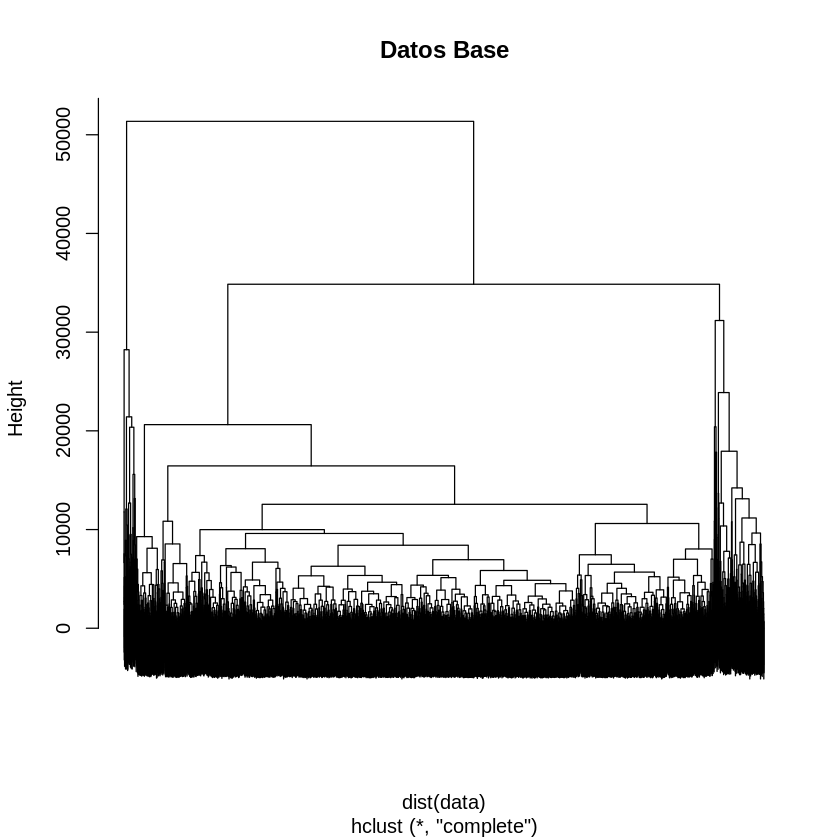

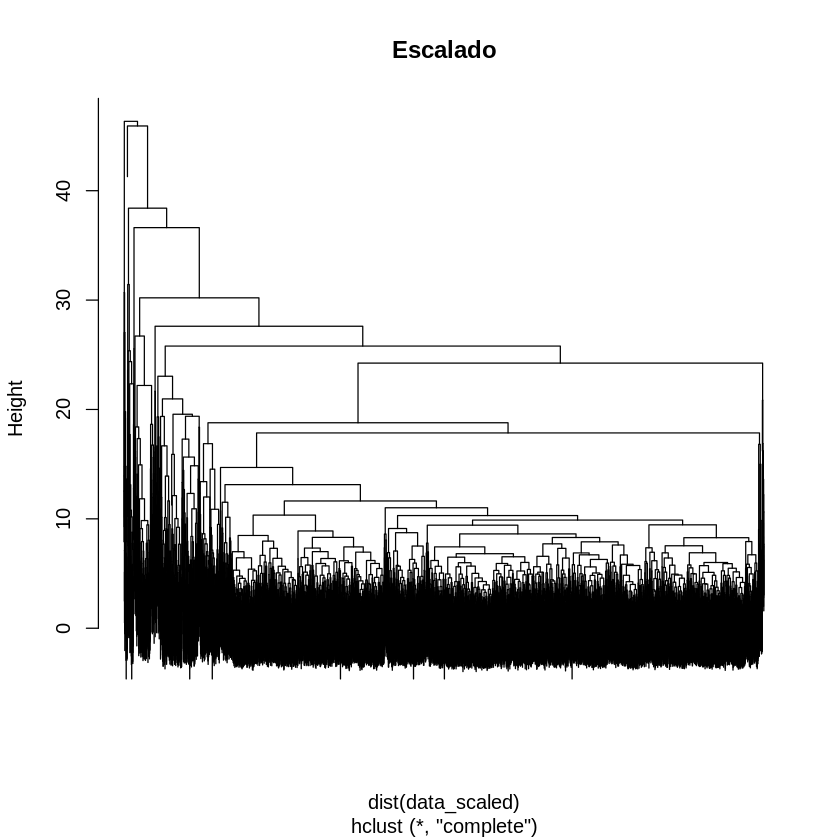

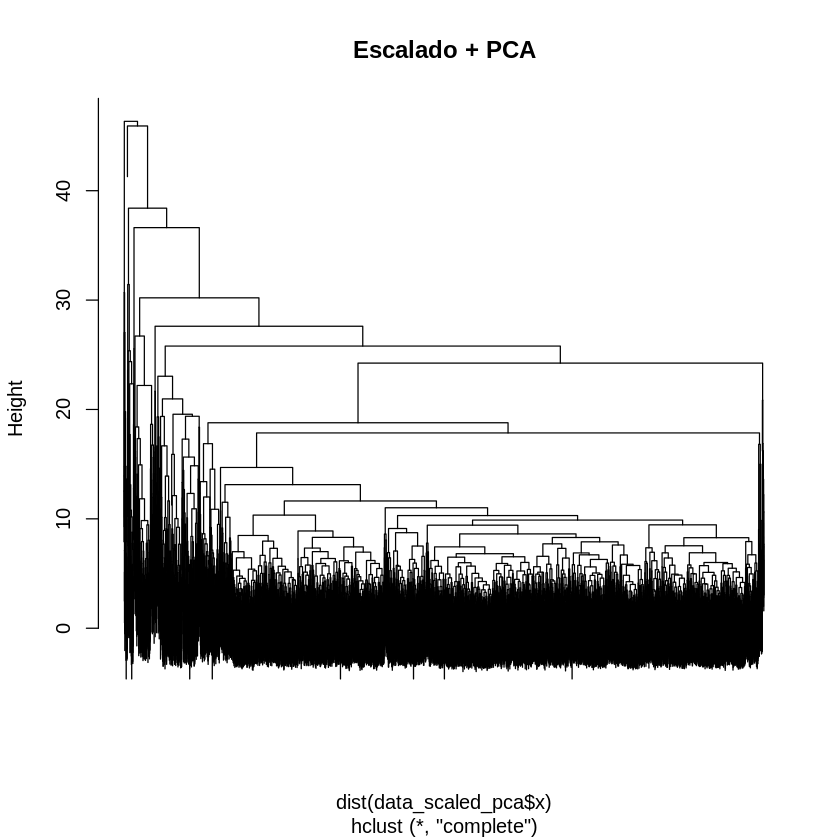

In [ ]:
plot(hclust_data_complete, main="Datos Base", labels = FALSE)
plot(hclust_data_scaled_complete, main="Escalado", labels = FALSE)
plot(hclust_data_scaled_pca_complete, main="Escalado + PCA", labels = FALSE)
plot(hclust_data_scaled_pca_scaled_complete, main="Escalado + PCA + Escalado", labels = FALSE)
plot(hclust_data_pca_complete, main="PCA", labels = FALSE)
plot(hclust_data_pca_scaled_complete, main="PCA + Escalado", labels = FALSE)

Al igual que lo sucedido con average linkage, no logramos obtener que las primera división en dos clusters sea balanceada, por lo que los resultados esperados son también muy malos.

##### Análisis de clusters

In [ ]:
hclust_data_complete_cutted <- cutree(hclust_data_complete, k = 2)
hclust_data_scaled_complete_cutted <- cutree(hclust_data_scaled_complete, k = 2)
hclust_data_scaled_pca_complete_cutted <- cutree(hclust_data_scaled_pca_complete, k = 2)
hclust_data_scaled_pca_scaled_complete_cutted <- cutree(hclust_data_scaled_pca_scaled_complete, k = 2)
hclust_data_pca_complete_cutted <- cutree(hclust_data_pca_complete, k = 2)
hclust_data_pca_scaled_complete_cutted <- cutree(hclust_data_pca_scaled_complete, k = 2)

In [ ]:
cat("------- Datos Base -------\n")
compare_clusters(class, hclust_data_complete_cutted)
cat("\n\n------- Escalado -------\n")
compare_clusters(class, hclust_data_scaled_complete_cutted)
cat("\n\n------- Escalado + PCA -------\n")
compare_clusters(class, hclust_data_scaled_pca_complete_cutted)
cat("\n\n------- Escalado + PCA + Escalado -------\n")
compare_clusters(class, hclust_data_scaled_pca_scaled_complete_cutted)
cat("\n\n------- PCA -------\n")
compare_clusters(class, hclust_data_pca_complete_cutted)
cat("\n\n------- PCA + Escalado -------\n")
compare_clusters(class, hclust_data_pca_scaled_complete_cutted)

------- Datos Base -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.9 %
      cluster_result
class     1    2
  blue 3988   65
  red  3863   84


------- Escalado -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.2 %
      cluster_result
class     1    2
  blue 4013   40
  red  3944    3


------- Escalado + PCA -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.2 %
      cluster_result
class     1    2
  blue 4013   40
  red  3944    3


------- Escalado + PCA + Escalado -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.67 %
      cluster_result
class     1    2
  blue 4053    0
  red  3946    1


------- PCA -------
Direct agreement: 1 of 2 pairs
Iterations for permutation matching: 1 
Cases in matched pairs: 50.9 %
      cluster_result
class     1    2
  blue 398

###### Análisis
Nuevamente los resultados son muy malos logrando un 50.9% de coincidencia.

En este caso, más del 98% de los puntos terminaron en un mismo cluster para todos los datasets, demostrando que complete linkage es mas sensible a puntos mas alejados que average.

## Cantidad de clusters

### Determinar cantidad

Esto tardó muchisimo por lo que lo tuve que correr en local

In [ ]:
k_stability_data <- stability(data)
k_gap_data <- gap_statistic(data)

k_stability_data_scaled <- stability(data_scaled)
k_gap_data_scaled <- gap_statistic(data_scaled)

k_stability_data_scaled_pca <- stability(data_scaled_pca$x)
k_gap_data_scaled_pca <- gap_statistic(data_scaled_pca$x)

k_stability_data_scaled_pca_scaled <- stability(data_scaled_pca_scaled)
k_gap_data_scaled_pca_scaled <- gap_statistic(data_scaled_pca_scaled)

k_stability_data_pca <- stability(data_pca$x)
k_gap_data_pca <- gap_statistic(data_pca$x)

k_stability_data_pca_scaled <- stability(data_pca_scaled)
k_gap_data_pca_scaled <- gap_statistic(data_pca_scaled)

In [ ]:
load("/content/k_gap_data.RData")
load("/content/k_gap_data_pca.RData")
load("/content/k_gap_data_pca_scaled.RData")
load("/content/k_gap_data_scaled.RData")
load("/content/k_gap_data_scaled_pca.RData")
load("/content/k_gap_data_scaled_pca_scaled.RData")

load("/content/k_stability_data.RData")
load("/content/k_stability_data_pca.RData")
load("/content/k_stability_data_pca_scaled.RData")
load("/content/k_stability_data_scaled.RData")
load("/content/k_stability_data_scaled_pca.RData")
load("/content/k_stability_data_scaled_pca_scaled.RData")

In [ ]:
cat("------- Datos Originales ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data, "\n\n")
cat("El K elegido con Stability es", k_stability_data, "\n\n\n")

cat("------- Escalado ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data_scaled, "\n\n")
cat("El K elegido con Stability es", k_stability_data_scaled, "\n\n")

cat("------- Escalado + PCA ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data_scaled_pca, "\n\n")
cat("El K elegido con Stability es", k_stability_data_scaled_pca, "\n\n")

cat("------- Escalado + PCA + Escalado ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data_scaled_pca_scaled, "\n\n")
cat("El K elegido con Stability es", k_stability_data_scaled_pca_scaled, "\n\n")

cat("-------  PCA ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data_pca, "\n\n")
cat("El K elegido con Stability es", k_stability_data_pca, "\n\n")

cat("------- PCA + Escalado ------- \n")
cat("El K elegido con Gap Statistic es", k_gap_data_pca_scaled, "\n\n")
cat("El K elegido con Stability es", k_stability_data_pca_scaled, "\n\n")

------- Datos Originales ------- 
El K elegido con Gap Statistic es 2 

El K elegido con Stability es 2 


------- Escalado ------- 
El K elegido con Gap Statistic es 7 

El K elegido con Stability es 2 

------- Escalado + PCA ------- 
El K elegido con Gap Statistic es 7 

El K elegido con Stability es 2 

------- Escalado + PCA + Escalado ------- 
El K elegido con Gap Statistic es 1 

El K elegido con Stability es 2 

-------  PCA ------- 
El K elegido con Gap Statistic es 2 

El K elegido con Stability es 2 

------- PCA + Escalado ------- 
El K elegido con Gap Statistic es 1 

El K elegido con Stability es 2 



#### Análisis
Stability determinó para todos los datasets que había dos clusters. Esto si bien puede parecer lógico, tengamos en cuenta que la implementación de stability que estamos usando no tiene forma de determinar que no hubo ningún cluster. De todas formas, ya hicimos la busqueda de dos clusters previamente.

Gap Statistic determinó que con los datos escalados y con los datos escalados + PCA había 7 clusters. Me parece algo raro pero vamos a buscar a continuación en Escalado + PCA para por lo menos poder ver que hay y poder visualizarlo. En todos los otros casos determinó que no había ningún cluster.

### Busqueda de 7 clusters

Ahora busquemos 7 clusters en uno de los datasets donde Gap Statistic determinó que los había, en particular lo hago sobre el dataset de la PCA ya que puedo mostrar las dimensiones mas importantes de la misma, con el otro no puedo saber que variables tengo que mirar para encontrar los 7 clusters.

In [ ]:
centers = 7
kmeans_k7_data_scaled_pca <- kmeans(data_scaled_pca$x, centers=centers, nstart = 20)

In [ ]:
pairs(data_scaled_pca$x[, 1:6], col=as.numeric(as.factor(kmeans_k7_data_scaled_pca$cluster)))

Hay algunos muy obvios como el negro y el azul. Mirando la tercera dimensión se puede ver como hay 3 de los clusters que parecen ser zonas pequeñas pero muy densas, eso puede explicar el número de 7 clusters. De todas formas no se como encontrarle un significado y tampoco tengo nada contra que comparar estas agrupaciones.

# Clasificación

La optimización de parámetros la hice con CV y luego la selección del modelo lo hice usando un test fijo debido a la cantidad de tiempo que me tomó ejecutar esta parte. Hubiera sido mejor hacer nested cross-validation pero usando un test fijo me tomo cerca de 1 día y medio de computo usando una implemetación que corría en paralelo, si hubiera usado Nested CV esto se hubiera multiplicado aproximadamente por 5, imposibilitando la ejecución debido a falta de tiempo al momento de llegar a este apartado.

De todas formas teniendo 8000 datos, al usar 20% para test tenemos 1600 samples para probar el modelo, esto me parece una cantidad razonable.

In [ ]:
data_general <- data
class_general <- class

test_general_indices <- sample(1:nrow(data_general), size = (0.2 * nrow(data_general)))
test_general_x <- data_general[test_general_indices, ]
test_general_y <- class_general[test_general_indices]
train_general_x <- data_general[-test_general_indices, ]
train_general_y <- class_general[-test_general_indices]

In [ ]:
load("./train_general_x.RData")
load("./train_general_y.RData")
load("./test_general_x.RData")
load("./test_general_y.RData")

## Optimizacion de parámetros

Todas las optmizaciones de parámetros las corrí en local y en paralelo, es por esto que para cada método tenemos un load de los resultados.

### Random Forest

In [ ]:
results_rf <- data.frame(Mtry = numeric(), Error = numeric(), stringsAsFactors = FALSE)

mtry_values <- floor(ncol(train_general_x) * (1 / 2)^(0:5))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtryv in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      x = train_general_x,
      y= train_general_y,
      mtry = mtryv,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }

  errors_avg <- c(errors_avg, mean(errors))
  results_rf <- rbind(results_rf, data.frame(Mtry = mtryv, Error = errors_avg[length(errors_avg)]))
}

In [1]:
load("/content/results_rf.RData")

In [4]:
print(kable(results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry|     Error|
|----:|---------:|
|   42| 0.2669063|
|   21| 0.2600000|
|   10| 0.2578437|
|    5| 0.2568437|
|    2| 0.2554688|
|    1| 0.2615000|


In [5]:
min_error <- min(results_rf$Error)
best_results_rf <- results_rf[results_rf$Error == min_error, ]
print(kable(best_results_rf, format.args = list(scientific = FALSE), align = "r"))



|   | Mtry|     Error|
|:--|----:|---------:|
|5  |    2| 0.2554688|


Me pareció muy raro que el mejor resultado se logró con mtry = 2. Cabe aclarar que esto no es un caso particular, lo corrí varias veces y casi siempre 2 era el mejor, seguido muy de cerca por 5 que es el valor mas cercano a la raíz cuadrada de 42 que es 6.48.

### XGBoosting

In [ ]:
results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000
learning_rates <- c(0.01, 0.05, 0.1, 0.3)
profs <- 1:20
num_folds <- 5
folds <- cut(seq(1, nrow(train_general_x)), breaks = num_folds, labels = FALSE)

for(i in 1:length(learning_rates)) {
  for(j in 1:length(profs)) {
    error_kfold <- k_fold_cv_xgboost(train_general_x, train_general_y, folds, learning_rates[i], nrounds, profs[j], num_folds)
    results_xgb <- rbind(results_xgb, data.frame(LearningRate = learning_rates[i], Prof = profs[j], Error = error_kfold))
  }
}

In [ ]:
load("/content/results_xgb.RData")

In [ ]:
print(kable(results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof|     Error|
|------------:|----:|---------:|
|         0.01|    1| 0.3051563|
|         0.01|    2| 0.2764062|
|         0.01|    3| 0.2746875|
|         0.01|    4| 0.2732813|
|         0.01|    5| 0.2743750|
|         0.01|    6| 0.2725000|
|         0.01|    7| 0.2771875|
|         0.01|    8| 0.2785938|
|         0.01|    9| 0.2879687|
|         0.01|   10| 0.2964062|
|         0.01|   11| 0.3018750|
|         0.01|   12| 0.3028125|
|         0.01|   13| 0.3106250|
|         0.01|   14| 0.3100000|
|         0.01|   15| 0.3165625|
|         0.01|   16| 0.3214063|
|         0.01|   17| 0.3206250|
|         0.01|   18| 0.3229687|
|         0.01|   19| 0.3242188|
|         0.01|   20| 0.3251562|
|         0.05|    1| 0.2871875|
|         0.05|    2| 0.2653125|
|         0.05|    3| 0.2768750|
|         0.05|    4| 0.2743750|
|         0.05|    5| 0.2764062|
|         0.05|    6| 0.2767188|
|         0.05|    7| 0.2804687|
|         0.05|    8| 0.2867188|
|       

In [ ]:
min_error <- min(results_xgb$Error)
best_results_xgb <- results_xgb[results_xgb$Error == min_error, ]
print(kable(best_results_xgb, format.args = list(scientific = FALSE), align = "r"))



|   | LearningRate| Prof|   Error|
|:--|------------:|----:|-------:|
|61 |          0.3|    1| 0.26375|


El mejor resultado se logró con Learning rate de 0.3 y arboles de profundidad 1.

### SVM - RBF

In [ ]:
results_svmrbf <- data.frame(Cost = numeric(),
                      Gamma = numeric(),
                      Error = numeric(),
                      stringsAsFactors = FALSE)

costs <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)
num_folds <- 5
folds <- cut(seq(1, nrow(train_general_x)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    suppressWarnings(error_kfold <- k_fold_cv_svm_RBF(train_general_x, train_general_y, folds, costs[i], gammas[j], num_folds))
    results_svmrbf <- rbind(results_svmrbf, data.frame(Cost = costs[i], Gamma = gammas[j], Error = error_kfold))
  }
}

In [ ]:
load("/content/results_svmrbf.RData")

In [ ]:
print(kable(results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|         Cost|       Gamma|     Error|
|------------:|-----------:|---------:|
|      0.00001|    0.000001| 0.5050000|
|      0.00001|    0.000010| 0.5050000|
|      0.00001|    0.000100| 0.5050000|
|      0.00001|    0.001000| 0.5050000|
|      0.00001|    0.010000| 0.5050000|
|      0.00001|    0.100000| 0.5050000|
|      0.00001|    1.000000| 0.5050000|
|      0.00001|   10.000000| 0.5050000|
|      0.00001|  100.000000| 0.5050000|
|      0.00001| 1000.000000| 0.5050000|
|      0.00010|    0.000001| 0.5050000|
|      0.00010|    0.000010| 0.5050000|
|      0.00010|    0.000100| 0.5050000|
|      0.00010|    0.001000| 0.5050000|
|      0.00010|    0.010000| 0.5050000|
|      0.00010|    0.100000| 0.5050000|
|      0.00010|    1.000000| 0.5050000|
|      0.00010|   10.000000| 0.5050000|
|      0.00010|  100.000000| 0.5050000|
|      0.00010| 1000.000000| 0.5050000|
|      0.00100|    0.000001| 0.5050000|
|      0.00100|    0.000010| 0.5050000|
|      0.00100|    0.000100| 0.5050000

In [ ]:
min_error <- min(results_svmrbf$Error)
best_results_svmrbf <- results_svmrbf[results_svmrbf$Error == min_error, ]
print(kable(best_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|    |   Cost|    Gamma|     Error|
|:---|------:|--------:|---------:|
|101 | 100000| 0.000001| 0.2510938|


El mejor resultado lo obtuvimos con un costo muy alto y un gamma muy bajo. Me sorprende el error obtenido que de momento es mas bajo que XGBoost y Random Forest.

### SVM - Polinomial

In [ ]:
results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Error = numeric(), stringsAsFactors = FALSE)

costs <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)
degrees <- 1:5
num_folds <- 5
folds <- cut(seq(1, nrow(train_general_x)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    for(k in 1:length(degrees)) {
      suppressWarnings(error_kfold <- k_fold_cv_svm_polinomial(train_general_x, train_general_y, folds, costs[i], gammas[j], degrees[k], num_folds))
      results_svmp <- rbind(results_svmp, data.frame(Cost = costs[i], Gamma = gammas[j], Degree = degrees[k], Error = error_kfold))
    }
  }
}

In [ ]:
load("/content/results_svmp.RData")

In [ ]:
print(kable(results_svmp, format.args = list(scientific = FALSE), align = "r"))



|         Cost|       Gamma| Degree|     Error|
|------------:|-----------:|------:|---------:|
|      0.00001|    0.000001|      1| 0.5050000|
|      0.00001|    0.000001|      2| 0.5050000|
|      0.00001|    0.000001|      3| 0.5050000|
|      0.00001|    0.000001|      4| 0.5050000|
|      0.00001|    0.000001|      5| 0.5050000|
|      0.00001|    0.000010|      1| 0.5050000|
|      0.00001|    0.000010|      2| 0.5050000|
|      0.00001|    0.000010|      3| 0.5050000|
|      0.00001|    0.000010|      4| 0.5050000|
|      0.00001|    0.000010|      5| 0.5050000|
|      0.00001|    0.000100|      1| 0.5050000|
|      0.00001|    0.000100|      2| 0.5050000|
|      0.00001|    0.000100|      3| 0.5050000|
|      0.00001|    0.000100|      4| 0.5050000|
|      0.00001|    0.000100|      5| 0.5050000|
|      0.00001|    0.001000|      1| 0.5050000|
|      0.00001|    0.001000|      2| 0.5050000|
|      0.00001|    0.001000|      3| 0.5050000|
|      0.00001|    0.001000|      4| 0

In [ ]:
min_error <- min(results_svmp$Error)
best_results_svmp <- results_svmp [results_svmp$Error == min_error, ]
print(kable(best_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|    | Cost| Gamma| Degree|     Error|
|:---|----:|-----:|------:|---------:|
|371 |  100| 0.010|      1| 0.2504688|
|416 | 1000| 0.001|      1| 0.2504688|


Podemos ver que logramos los errores mas bajos con dos combinaciones distintas, ambas con un error menor a 0.2505 siendo los mas bajos obtenidos con la optimizacion de parámetros.

## Comparación

Ahora entrenemos los distintos métodos con los mejores parámetros obtenidos y con todo el conjunto de train y comparemoslos entre ellos evaluando en test.

### RandomForest

In [ ]:
final_results_rf <- data.frame(Mtry = numeric(),
                               Train_Error = numeric(),
                               Test_Error = numeric(),
                               stringsAsFactors = FALSE)
tree_count <- 1000

for (i in 1:nrow(best_results_rf)) {
  mtry <- best_results_rf$Mtry[i]

  rf_model <- randomForest(
    x=train_general_x,
    y=train_general_y,
    mtry = mtry,
    ntree = tree_count
  )

  train_pred_rf <- predict(rf_model, train_general_x)
  train_error_rf <- mean(train_pred_rf != train_general_y)

  test_pred_rf <- predict(rf_model, test_general_x)
  test_error_rf <- mean(test_pred_rf != test_general_y)

  final_results_rf <- rbind(final_results_rf, data.frame(Mtry = mtry, Train_Error = train_error_rf, Test_Error = test_error_rf))
}

In [ ]:
print(kable(final_results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Train_Error| Test_Error|
|----:|-----------:|----------:|
|    2|   0.1160938|   0.256875|


### XGBoost

In [ ]:
final_results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000

for (i in 1:nrow(best_results_xgb)) {
  # Obtener los parámetros de la fila actual
  best_lr <- best_results_xgb$LearningRate[i]
  best_max_depth <- best_results_xgb$Prof[i]

  # Entrenar el modelo XGBoost con los mejores parámetros
  m.xgb <- xgboost(
    data = as.matrix(train_general_x),
    label = as.integer(train_general_y) - 1,
    objective = "binary:hinge",
    nrounds = nrounds,
    early_stopping_rounds = 1000,
    eta = best_lr,
    max.depth = best_max_depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train_pred_xgb <- predict(m.xgb, as.matrix(train_general_x))
  train_error_xgb <- mean(train_pred_xgb != (as.integer(train_general_y) - 1))

  test_pred_xgb <- predict(m.xgb, as.matrix(test_general_x))
  test_error_xgb <- mean(test_pred_xgb != (as.integer(test_general_y) - 1))

  final_results_xgb <- rbind(final_results_xgb, data.frame(LearningRate = best_lr,
                                                           Prof = best_max_depth,
                                                           Train_Error = train_error_xgb,
                                                           Test_Error = test_error_xgb))
}

In [ ]:
print(kable(final_results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Train_Error| Test_Error|
|------------:|----:|-----------:|----------:|
|          0.3|    1|    0.230625|       0.27|


El error de train no llego a cero, lo que me hace pensar que faltaron iteraciones, pero me parece que 1000 es un número lo suficientemente grande y no quiero usar una cantidad distinta a la usada en la optimizacion de parámetros.

### SVM RBF

In [ ]:
final_results_svmrbf <- data.frame(Cost = numeric(), Gamma = numeric(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmrbf)) {
  # Obtener los parámetros de la fila actual
  best_cost <- best_results_svmrbf$Cost[i]
  best_gamma <- best_results_svmrbf$Gamma[i]

  # Entrenar el modelo SVM con los mejores parámetros
  suppressWarnings(svm_model <- svm(
    x = train_general_x,
    y = train_general_y,
    type = 'C-classification',
    kernel = "radial",
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmrbf <- predict(svm_model, train_general_x)
  train_error_svmrbf <- mean(train_pred_svmrbf != train_general_y)

  test_pred_svmrbf <- predict(svm_model, test_general_x)
  test_error_svmrbf <- mean(test_pred_svmrbf != test_general_y)

  # Guardar los resultados en el dataframe
  final_results_svmrbf <- rbind(final_results_svmrbf, data.frame(Cost = best_cost, Gamma = best_gamma, Train_Error = train_error_svmrbf, Test_Error = test_error_svmrbf))
}


In [ ]:
print(kable(final_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   Cost|    Gamma| Train_Error| Test_Error|
|------:|--------:|-----------:|----------:|
| 100000| 0.000001|   0.2507813|   0.255625|


### SVM Polinomial

In [ ]:
final_results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmp)) {
  best_cost <- best_results_svmp$Cost[i]
  best_gamma <- best_results_svmp$Gamma[i]
  best_degree <- best_results_svmp$Degree[i]

  suppressWarnings(svm_model <- svm(
    x = train_general_x,
    y = train_general_y,
    type = 'C-classification',
    kernel = "polynomial",
    degree = best_degree,
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmpol <- predict(svm_model, train_general_x)
  train_error_svmpol <- mean(train_pred_svmpol != train_general_y)

  test_pred_svmpol <- predict(svm_model, test_general_x)
  test_error_svmpol <- mean(test_pred_svmpol != test_general_y)

  final_results_svmp <- rbind(final_results_svmp, data.frame(Cost = best_cost, Gamma = best_gamma, Degree = best_degree, Train_Error = train_error_svmpol, Test_Error = test_error_svmpol))
}

In [ ]:
print(kable(final_results_svmp, format.args = list(scientific = FALSE), align = "r"))



| Cost| Gamma| Degree| Train_Error| Test_Error|
|----:|-----:|------:|-----------:|----------:|
|  100| 0.010|      1|   0.2492188|     0.2575|
| 1000| 0.001|      1|   0.2495312|     0.2575|


### Gráfica

In [ ]:
modelos <- c("RF", "Boosting", "SVM RBF", "SVM P")
errores_test <- c(min(final_results_rf$Test_Error), min(final_results_xgb$Test_Error), min(final_results_svmrbf$Test_Error), min(final_results_svmp$Test_Error))

barplot(height = errores_test,
        names.arg = modelos,
        xlab = "Modelo",
        ylab = "Error",
        col = "lightblue",
        border = "blue",
        main = "Errores en Test de los Modelos")

Sorprendentemete XGBoost fue el modelo que obtuvo el peor resultado. El mejor fue el logrado con SVM RBF.

De todas formas podemos ver que todos los modelos estuvieron muy cerca del 75% de accuracy lo cual parece ser el error mínimo que se puede obtener.

No me parece un mal resultado ya que son datos de las partidas a 10 minutos de las mismas y muchas veces llegan a durar 40 miuntos o más, por lo que poder predecir con solo 25% de error quien va a ganar con tan poco tiempo transcurrido de partida me parece destacable.

Estos modelos logrados me parecen muy útiles para poder hacer una predicción en tiempo real de partidas profesionales para mostrar que equipo tiene mas chances de ganar.